In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory``````````
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
            
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


___

**House Price prediction:**<br> I'm attempting this competition a second time here, my first attempt was 4 months ago, with a public score of 0.16806, when I didn't analyse the data extensively and feature selection was based on assumptions. My goal this time is to get better at my **EXPLORATORY DATA ANALYSIS-EDA** and overall process and not just to improvise the score. We will be analysing data extensively based on statistics and not on assumptions<br><br>
**Update:** EDA and Feature Engineered data in this notebook coupled with a basic Linear Regression model got an improvement in the score(rmse: 0.14285) compared to my previous notebook attempt using Hyperparameter tuned Lasso Regression(rmse: 0.16806), I think that implies deeper Data Analysis alone can greatly improve the performance without the need for using complex models for training. May be that's why we hear lot of Data Scientists stressing on the importance of preparing and working on the data rather than fancy models.<br><br>Please upvote if you find the notebook useful

***

Our goal is to predict the SalePrice of a house by training our model on a given set of data.<br> In this dataset, we have 81 columns and 1460 rows.<br> SalePrice column is the **target/dependant variable** whose value, the model should be able to predict <br> Remaining 80 columns are the **features/independent variables** whose values will affect the value of the target. <br> This is a regression problem since the prediciton variable is a continuous variable (Price value of a house)


___

## Index

#### Exploratory Data Analysis & Feature Selection

   1. Inspect data
   
   2. Handle missing values
    
        2.1 Missing values in Numerical features<br>
        2.2 Missing values in Categorical features
        
   3. Data analysis & Feature selection - Numerical
          
        3.1 Pairwise Correlation        
        3.2 Correlation matrix & Heatmap       
        3.3 Feature Analysis based on Correlation
    
   4. Data analysis & Feature selection - Categorical
   
#### Data Pre-Processing
    
   5. Skewness and Normalisation

   6. Training set-Validation set split, Pre-processing steps: OneHotEncoding, Standardisation
    
#### Model Training, Evaluation &  Validation
    
   7. Extreme Gradient Boosting(XGB) Regressor
    
        7.1 Hyperparameter Tuning        
        7.2 Plotting Decision trees        
        7.3 Feature importance        
        7.4 Predicted vs Actual plot       
        7.5 Residual plot       
        7.6 Learning Curve-Bias/variance Tradeoff
        
#### Target Prediction
        
   8. Predict target for Test Data<br><br>  
   
                
                   
   References:
   
   - [Inspiration from Gabriel Atkin's ML process pipeline video](https://www.youtube.com/watch?v=zwYHloLXH0c&t=5885s)   
   - [Kaggle notebook by Abu Bakar](https://www.kaggle.com/bakar31/eda-house-price-prediction)           
   - [My earlier attempt of this problem](https://www.kaggle.com/iravad/house-price-advanced-regression-techniques-lasso)
    
     
    

We import the library requirements here

In [2]:
# import libraries
pd.options.display.max_columns=None
pd.options.display.max_rows=85
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import plot_tree, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve

Then we read in the Train, Test and sample_submission datasets

In [3]:
# read training and testing CSV data to dataframes train & test respectively
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

## 1. Inspect Data

We start inspecting the Training data, let's take a visual look at the features and Target and let's try to understand the given set of properties of a house. We may not understand the data in-depth for now, that's okay. Let's just get to know about the data first. We will do a full exploratory analysis later to get into the technicalities of each feature

In [4]:
# inspect the shape of the train & test dataframes
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


**Train** has 1460 data observations, 80 features + 1 target(SalePrice column)<br> **Test** has 1459 data observations, 80 features<br> We have to train a model using the given train data and predict SalePrice for the test data<br> The **EDA findings from train data will be used for preparing and pre-processing the test data**

Most datasets for predicitons have both *Numerical* and *Categorical* data<br>Features like __LotFrontage, LotArea__ have numerical data giving details of area in square feet<br>Features like __Lotshape, Utilities__ denote categories like Reg(Regular)/AllPub(All public Utilities (E,G,W,& S))

In [5]:
# inspect train
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

Looking at the datatypes, non-null count of all the features, we will roughly have an idea about the columns and their missing values in general

In [6]:
# dataframe information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Let's observe the satistical details for __all numerical features__ like count, minimun value, maximum value, mean value, standard deviation etc. <br> This will help us to understand the data more statistically <br> For example, <br> In the entire dataset which is the oldest year of construction and latest year of construction of house?<br>Also, observe the columns __MSSubClass, OverallQual__ & __OverallCond__, could you spot anything different in these columns?

In [7]:
# statistics of train
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


The __YearBuilt__ - *Original construction date*, statistics shows min value of original construction as 1872 and max values as 2010!<br> Please note that __MSSubClass, OverallQual__ & __OverallCond__ have **numerical data** but on a closer inspection of min, 25%, 50%, 75% & max values, they are **Categorical variables** indicating categories & **ratings** as numbers! We can confirm this by looking at the data description of these features 

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
       
 OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

let's convert them into **Categorical datatypes**

In [8]:
# converting 'int' datatype to 'object' datatype for train data
train["MSSubClass"] = train["MSSubClass"].astype(str)
train["OverallQual"] = train["OverallQual"].astype(str)
train["OverallCond"] = train["OverallCond"].astype(str)

In [9]:
# converting 'int' datatype to 'object' datatype for test data
test["MSSubClass"] = test["MSSubClass"].astype(str)
test["OverallQual"] = test["OverallQual"].astype(str)
test["OverallCond"] = test["OverallCond"].astype(str)

Let's see **the list of Numerical and Categorical features** in the dataset

In [10]:
# categorical columns include "object" datatypes
cat_cols = train.select_dtypes(include="object").columns
cat_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# numerical columns exclude "object" datatypes
num_cols = train.select_dtypes(exclude="object").columns
num_cols

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Let's take a look at the **target**

In [12]:
# SalePrice column
train["SalePrice"]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

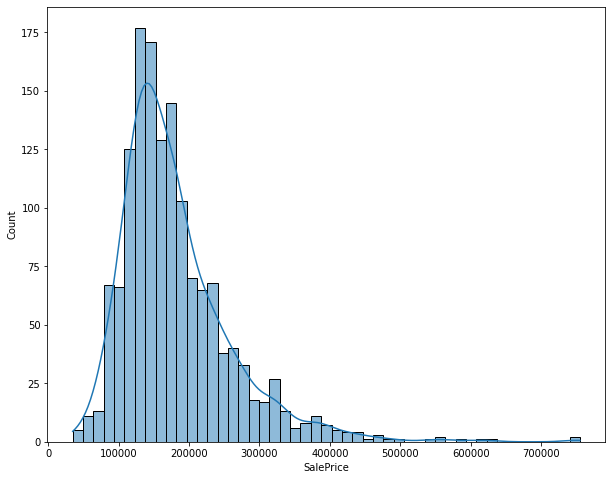

In [13]:
# SalePrice histogram
plt.figure(figsize=(10, 8))
sns.histplot(train["SalePrice"], kde=True)

The SalePrice for maximum number of houses in the data is in between the price range 100000 and 200000. The data is **skewed** with more houses in the price range upto $ 300000 and on the right side of the histogram, there are very less number of houses with more SalePrice

#### [Go to Index](#Index)

***

## 2. Handle missing values

It's always good to analyse for any missing values in a dataset and clean the dataset before training our model

Now, it's time for **datacleaning**<br>There are many ways to deal with null values:
- drop the rows with null values(we're not choosing this method here since information will be lost if rows are dropped)
- **drop** the entire column with null values
   - if the data is missing at random, 
   - if column becomes redundant & 
   - if we don't have a reason to have that column for training   
- **impute** missing values
   - if the data is not missing at random, 
   - if we can find why the values are missing & 
   - we have a reason to keep the column for training

Before deciding on the method(dropping or imputing), list out all the Null/missing values from the entire dataset

In [14]:
# missing value in train data
missing_values = train.isna().sum().sort_values(ascending=False)
missing_values

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

<AxesSubplot:>

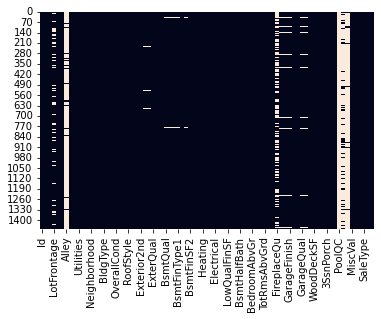

In [15]:
# visualising null values in train
sns.heatmap(train.isnull(), cbar=False)

There are missing values in both categorical and numerical features, each of them need separate treatment for dealing with missing values<br> First, let's see the missing values in __Numerical features__

#### [Go to Index](#Index)

***

## 2.1 Missing values in Numerical features

In [16]:
# missing values in numerical features of train
(train.select_dtypes(exclude='object')).isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
OpenPorchSF       0
TotRmsAbvGrd      0
Fireplaces        0
GarageCars        0
GarageArea        0
WoodDeckSF        0
Id                0
dtype: int64

For numerical variables, we will **impute** missing values with the mean/median of the column data (depending on the type of value column<br> for example, for area values we can impute using mean and for age/year values we can impute using median values)

__LotFrontage__ has 259 null values<br>LotFrontage: Linear feet of street connected to property

In [17]:
# getting unique values and their counts in LotFrontage column
train["LotFrontage"].value_counts()

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

Let's observe this feature's relationship with target

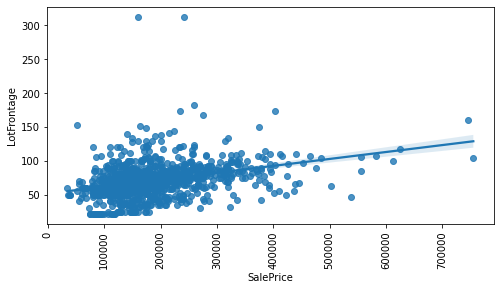

In [18]:
#plot feature LotFrontage vs target SalePrice
plt.figure(figsize=(8,4))
ax=sns.regplot(y="LotFrontage", x="SalePrice", data=train)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

*LotFrontage* has a linear relationship with *SalePrice*<br>let's impute the missing values using the mean value of the column

In [19]:
# impute mean for missing values
train["LotFrontage"].fillna(train["LotFrontage"].mean(), inplace=True)


In [20]:
# impute missing values in test data
test["LotFrontage"].fillna(train["LotFrontage"].mean(), inplace=True)

**GarageYrBlt** is the next numerical feature with 81 missing values<br>GarageYrBlt: Year garage was built <br>Let's analyse if the year the garage was built is the same as the *YearBuilt*(the year the house was built). <br> Garages *might* have been built along with the house at the same time, let's look into the statistcs<br>If they're the same, we can drop the *GarageYrBuilt* feature since it may be regarded as duplicate information

In [21]:
train[["GarageYrBlt", "YearBuilt"]]

,GarageYrBlt,YearBuilt
0,2003.0,2003
1,1976.0,1976
2,2001.0,2001
3,1998.0,1915
4,2000.0,2000
...,...,...
1455,1999.0,1999
1456,1978.0,1978
1457,1941.0,1941
1458,1950.0,1950


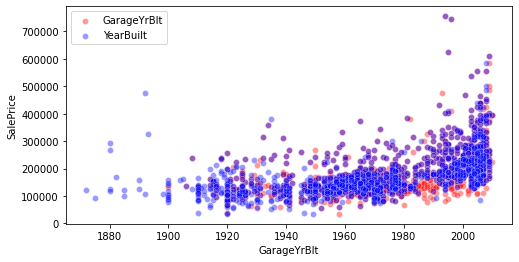

In [22]:
# plotting GarageYrBlt and YearBuilt vs SalePrice
plt.figure(figsize=(8,4))
sns.scatterplot(x="GarageYrBlt", y="SalePrice", data=train, color = 'r', alpha=0.4)
sns.scatterplot(x="YearBuilt", y="SalePrice", data=train, color='b', alpha=0.4)
plt.legend(labels = ["GarageYrBlt", "YearBuilt"])

The values look same except for few, many data points overlap<br>Statistics can help to get the real numbers!


In [23]:
# comparing if the row values are same for the features
compare = np.where(train["GarageYrBlt"] == train["YearBuilt"], True, False)
comparison = np.array(compare)
np.unique(comparison, return_counts=True)

(array([False,  True]), array([ 371, 1089]))

The values are same for 1089 data points(75% of data)<br>so we cannot drop the *GarageYrBlt* feature, for 25% of houses, Garage built year is different.<br> Let's locate the null values in the dataframe and investigate further how to impute those missing 81 values

In [24]:
# some of the null value rows in GarageYrBlt
train.loc[train["GarageYrBlt"].isnull()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,102,0,0,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
78,79,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,136500
88,89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
89,90,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600


Looking in the dataframe, we have null values in all columns related to Garage(GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond) for those 81 rows. That implies **those houses don't have a garage, so we cannot impute mean value here for *GarageYrBlt*, impute '0' for the null values**

In [25]:
# impute mean for missing values
train["GarageYrBlt"].fillna(0, inplace=True)

In [26]:
# impute missing values in test data
test["GarageYrBlt"].fillna(0, inplace=True)

Now, we've managed the missing values for Numerical Features. Let's analyse the missing values in __Categorical features__

#### [Go to Index](#Index)

***

## 2.2 Missing values in Categorical features

In [27]:
# missing values in categorical features of train
(train.select_dtypes(include='object')).isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
Functional         0
KitchenQual        0
CentralAir         0
HeatingQC          0
dtype: int64

We're having more null values in these columns:<br> **PoolQC          1453<br>
MiscFeature     1406<br>
Alley           1369<br>
Fence           1179**<br><br>They are **more than 80% of missing values** in each of the above columns, if missing values are more than 30% of total data we can drop the columns assuming that they don't contribute to overall performance. Imputing them with mean/median/mode without proper analysis will lead to bias in the model<br>Let's **analyse the reason** for the large percentage of missing data in certain features. Sometimes, missing values are not because of entry error/at random, they may be missing intentionally because the data is not applicable/intended to be in any of the categories

Exploring __PoolQC__ feature:

Why do you think *PoolQC* has 1453 null values? Investigate...<br>PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [28]:
train["PoolQC"].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

PoolArea: Pool area in square feet <br>is a feature related to *PoolQC*, inspect 

In [29]:
# get unique PoolArea value counts
train["PoolArea"].value_counts()

0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: PoolArea, dtype: int64

Now, it's clear that **PoolArea is 0** for same 1453 datapoints, that means 1453 houses in data **don't have pool**<br>Clearly *PoolArea* & *PoolQC* have **very low variance/nearly zero variance**, they won't help in improving the model performance, so we can drop *PoolArea & PoolQC*

#### Variance is the measure of spread between the unique values/categories in a column. If more than 95% of the values in the column belong to a specific category then we say the column has low variance. The 5% of values in other categories cannot help in prediction and the column is considered to be a constant. The column will not improve the model performance in predicting the target, so we can drop the column

In [30]:
# drop PoolArea & PoolQC columns
train.drop(columns=["PoolArea", "PoolQC"], axis=1, inplace=True)


In [31]:
# drop PoolArea & PoolQC columns in test data
test.drop(columns=["PoolArea", "PoolQC"], axis=1, inplace=True)


Next column with more null values is __MiscFeature__, let's investigate the reason<br>
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [32]:
# getting unique values and their counts in MiscFeature column
train["MiscFeature"].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

*MiscFeature* has 54 datapoints in 4 categories, we suspect missing 1406 datapoints may belong to the 'NA-None' category<br>Even if we impute the 1406(96%) datapoints with 'NA', the overall **variance** for the column will be **very low** & it will not contribute to the performance of the model. So drop the column

In [33]:
# drop MiscFeature column
train.drop(columns=["MiscFeature"], axis=1, inplace=True)


In [34]:
# drop MiscFeature column in test data
test.drop(columns=["MiscFeature"], axis=1, inplace=True)


Next feature to have more missing values is **Alley**, it has 1369 null values<br>
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [35]:
# getting unique value count for Alley
train["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

*Alley* has only 2 categories with 91 values<br> Missing 1369 values contribute to 93.7% of total data(threshold for low variance is 95%), so cannot be considered low variance & we cannot drop the column<br>Missing values must belong to 3rd category *NA - No alley access*<br>Let's impute 'NA' for missing values

In [36]:
# impute 'NA' for null values in Alley
train["Alley"].fillna('NA', inplace=True)

In [37]:
# impute null values for Alley in test data
test["Alley"].fillna('NA', inplace=True)

Next feature with missing values is **Fence**, 1179 values are missing, let's analyse:<br>
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [38]:
# getting counts of unique values in Fence
train["Fence"].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

By analysing at the count values in categories, the 1179 missing values beong to the missing category *NA - No Fence*, let's impute 'NA'

In [39]:
# impute 'NA' for null values in Fence
train["Fence"].fillna('NA', inplace=True)

In [40]:
# impute null values for Fence in test data
test["Fence"].fillna('NA', inplace=True)

**FireplaceQu** has 690 missing values<br>
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace


In [41]:
# getting counts of unique values in FireplaceQu
train["FireplaceQu"].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Missing values may be *NA-No fireplce*. we have another feature __Fireplaces__ that shows the number of fireplaces in the house, let's analyse this feature

In [42]:
# getting counts of unique values in Fireplaces
train["Fireplaces"].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

There are 690 counts of zero fireplaces, that matches with our 690 missing values in *FirelaceQu*, so impute them as 'NA - No Fireplace'

In [43]:
# impute 'NA' for missing values in FireplaceQu
train["FireplaceQu"].fillna("NA", inplace=True)

In [44]:
# impute for missing values in FireplaceQu in test data
test["FireplaceQu"].fillna("NA", inplace=True)

**GarageType, GarageFinish, GarageQual, GarageCond** all describing the properties of Garage, have 81 values missing<br>The 81 missing values are from **same rows** (we confirmed this when analysing the **GarageYrBlt** column)

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

All these features have a category 'NA' for 'No garage', the missing 81 values belong to 'NA'<br>Impute missing values as 'NA'

In [45]:
# imputing 'NA' for missing values
train["GarageType"].fillna('NA', inplace=True)
train["GarageFinish"].fillna('NA', inplace=True)
train["GarageQual"].fillna('NA', inplace=True)
train["GarageCond"].fillna('NA', inplace=True)


In [46]:
# imputing 'NA' for missing values in test data
test["GarageType"].fillna('NA', inplace=True)
test["GarageFinish"].fillna('NA', inplace=True)
test["GarageQual"].fillna('NA', inplace=True)
test["GarageCond"].fillna('NA', inplace=True)


__BsmtExposure, BsmtFinType2__ both features have 38 missing values, let's see if the missing values are from the same rows<br>
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
       
 BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [47]:
# getting uniuqe value counts for BsmtExposure
train["BsmtExposure"].value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [48]:
# getting uniuq value counts for BsmtFinType2
train["BsmtFinType2"].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [49]:
train.loc[train["BsmtExposure"].isnull()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
17,18,90,RL,72.0,10791,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,1296,0,0,1296,0,0,2,0,2,2,TA,6,Typ,0,NA,CarPort,1967.0,Unf,2,516,TA,TA,Y,0,0,0,0,0,NA,500,10,2006,WD,Normal,90000
39,40,90,RL,65.0,6040,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NA,NA,0.0,NA,0,0,NA,NA,N,0,0,0,0,0,NA,0,6,2008,WD,AdjLand,82000
90,91,20,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1950,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,FuseA,1040,0,0,1040,0,0,1,0,2,1,TA,4,Typ,0,NA,Detchd,1950.0,Unf,2,420,TA,TA,Y,0,29,0,0,0,NA,0,7,2006,WD,Normal,109900
102,103,90,RL,64.0,7018,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Fa,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,NA,Attchd,1979.0,Unf,2,410,TA,TA,Y,0,0,0,0,0,NA,0,6,2009,WD,Alloca,118964
156,157,20,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1950,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,Y,FuseF,1040,0,0,1040,0,0,1,0,2,1,TA,5,Typ,0,NA,Detchd,1950.0,Unf,2,625,TA,TA,Y,0,0,0,0,0,NA,0,6,2006,WD,Normal,109500


The missing 38 values are from **same rows** and category *NA - No Basement* is missing from both columns<br> Impute the missing values as 'NA'

In [50]:
# filling 'NA' for missing values
train["BsmtExposure"].fillna('NA', inplace=True)
train["BsmtFinType2"].fillna('NA', inplace=True)

In [51]:
# filling 'NA' for missing values in test data
test["BsmtExposure"].fillna('NA', inplace=True)
test["BsmtFinType2"].fillna('NA', inplace=True)

__BsmtCond, BsmtFinType1, BsmtQual__ features have 37 missing values, let's see if the missing values are from the same rows<br>
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
 
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [52]:
# unique value counts for BsmtQual
train["BsmtQual"].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [53]:
# unique value counts for BsmtCond
train["BsmtCond"].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [54]:
# unique value counts for BsmtFinType1
train["BsmtFinType1"].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [55]:
train.loc[train["BsmtQual"].isnull()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
17,18,90,RL,72.0,10791,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1967,1967,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,Slab,NaN,NaN,NA,NaN,0,NA,0,0,0,GasA,TA,Y,SBrkr,1296,0,0,1296,0,0,2,0,2,2,TA,6,Typ,0,NA,CarPort,1967.0,Unf,2,516,TA,TA,Y,0,0,0,0,0,NA,500,10,2006,WD,Normal,90000
39,40,90,RL,65.0,6040,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.0,TA,TA,PConc,NaN,NaN,NA,NaN,0,NA,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,NA,NA,0.0,NA,0,0,NA,NA,N,0,0,0,0,0,NA,0,6,2008,WD,AdjLand,82000
90,91,20,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1950,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,Slab,NaN,NaN,NA,NaN,0,NA,0,0,0,GasA,TA,Y,FuseA,1040,0,0,1040,0,0,1,0,2,1,TA,4,Typ,0,NA,Detchd,1950.0,Unf,2,420,TA,TA,Y,0,29,0,0,0,NA,0,7,2006,WD,Normal,109900
102,103,90,RL,64.0,7018,Pave,NA,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Fa,Slab,NaN,NaN,NA,NaN,0,NA,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,NA,Attchd,1979.0,Unf,2,410,TA,TA,Y,0,0,0,0,0,NA,0,6,2009,WD,Alloca,118964
156,157,20,RL,60.0,7200,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1950,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,NaN,NaN,NA,NaN,0,NA,0,0,0,GasA,TA,Y,FuseF,1040,0,0,1040,0,0,1,0,2,1,TA,5,Typ,0,NA,Detchd,1950.0,Unf,2,625,TA,TA,Y,0,0,0,0,0,NA,0,6,2006,WD,Normal,109500


The missing 37 values are *NA-No Basement*, they are from same rows as 'NA' is missing from above 3 features

In [56]:
# impute 'NA' for null values
train["BsmtQual"].fillna('NA', inplace=True)
train["BsmtCond"].fillna('NA', inplace=True)
train["BsmtFinType1"].fillna('NA', inplace=True)

In [57]:
# impute 'NA' for null values in test data
test["BsmtQual"].fillna('NA', inplace=True)
test["BsmtCond"].fillna('NA', inplace=True)
test["BsmtFinType1"].fillna('NA', inplace=True)

Checking for missing values in train again

In [58]:
# null values in train
train.isnull().sum().sort_values(ascending=False).head(5)

MasVnrType      8
MasVnrArea      8
Electrical      1
Id              0
BedroomAbvGr    0
dtype: int64

3 more Categorical features having missing values, let's analyse __MasVnrType & MasVnrArea__ together since they both represent the same property & both have 8 missing values

MasVnrType: Masonry veneer type
	
       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

In [59]:
# getting unique value count for MasVnrArea
train["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [60]:
# getting unique value count for MasVnrType
train["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In *MasVnrType*, "CBlock(Cinder Block)" category is missing, however without statistics confirmation, we cannot impute 'CBlock' for the 8 missing values, so we impute most frequent values in both columns:
- Impute **0** for missing values in *MasVnrArea*
- Impute **mode**('None' category) for *MasVnrType*

In [61]:
# impute most frequent values for MasVnrArea & MasVnrType
train["MasVnrArea"].fillna(0, inplace=True)
train["MasVnrType"].fillna(train["MasVnrType"].mode()[0], inplace=True)

In [62]:
# impute most frequent values for MasVnrArea & MasVnrType in test data
test["MasVnrArea"].fillna(0, inplace=True)
test["MasVnrType"].fillna(train["MasVnrType"].mode()[0], inplace=True)

Last feature with missing value is __Electrical__, with 1 missing value
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		

In [63]:
# getting unique value counts for Electrical
train["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Let's impute the most frequent category for the missing value

In [64]:
# impute most frequent category for null value
train["Electrical"].fillna(train["Electrical"].mode()[0], inplace=True)

In [65]:
# impute most frequent category for null value in test data
test["Electrical"].fillna(train["Electrical"].mode()[0], inplace=True)

We have successfully imputed missing values in numerical & categorical features! **No null values** in the train dataset now<br>Along the way we analysed the related features and removed 3 redundant features!!

<AxesSubplot:>

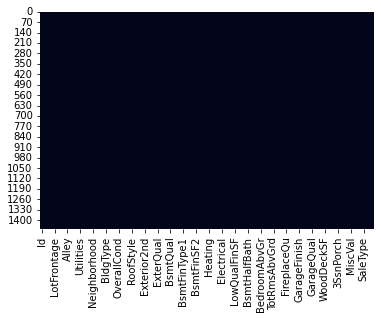

In [66]:
# check for null values in train
sns.heatmap(train.isnull(), cbar=False)

In [67]:
# checking null values in test data
test.isnull().sum()

Id               0
MSSubClass       0
MSZoning         4
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        2
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      1
Exterior2nd      1
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       1
BsmtFinType2     0
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     2
BsmtHalfBath     2
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr

**Test data has null values in more columns** than train data, we have to clean the test data by **imputing mean** for numerical columns and **mode** for categorical columns. We cannot drop the columns with missing values, since it will lead to shape mismatch later during the model training stage

In [68]:
# impute mean for numerical columns and mode for categorical columns in test data
test["MSZoning"].fillna(test["MSZoning"].mode()[0], inplace=True)
test["Exterior1st"].fillna(test["Exterior1st"].mode()[0], inplace=True)
test["Exterior2nd"].fillna(test["Exterior2nd"].mode()[0], inplace=True)
test["BsmtFinSF1"].fillna(test["BsmtFinSF1"].mean(), inplace=True)
test["TotalBsmtSF"].fillna(test["TotalBsmtSF"].mean(), inplace=True)
test["KitchenQual"].fillna(test["KitchenQual"].mode()[0], inplace=True)
test["Functional"].fillna(test["Functional"].mode()[0], inplace=True)
test["GarageCars"].fillna(test["GarageCars"].mean(), inplace=True)
test["SaleType"].fillna(test["SaleType"].mode()[0], inplace=True)

In [69]:
# check the shape of train and test after data cleaning
print(train.shape)
print(test.shape)

(1460, 78)
(1459, 77)


#### [Go to Index](#Index)

***

## 3. Data analysis & Feature selection - Numerical

Now that we took care of all missing values in the train data, let's first analyse Numerical features by selecting relevant features & dropping redundant features using statistics.<br> **Correlation matrix & heatmap** can be used to explore numerical features and their correlation values

In [70]:
# numerical features in train
train.select_dtypes(exclude='object')

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,2,2008,208500
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,5,2007,181500
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,9,2008,223500
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,2,2006,140000
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,8,2007,175000
1456,1457,85.0,13175,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,2,2010,210000
1457,1458,66.0,9042,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,2500,5,2010,266500
1458,1459,68.0,9717,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,4,2010,142125


## 3.1 Pairwise Correlation

Exploring the relationships between features is crucial in data analysis in order to select the best set of features. A pairplot helps to analyse each numerical feature in relation to every other numerical feature in a dataset<br> Since we have a lot of numerical features in train data, a single pairplot with all numerical columns becomes complex and takes a long time to execute. Let's plot 3 separate pairplots for better visualisation

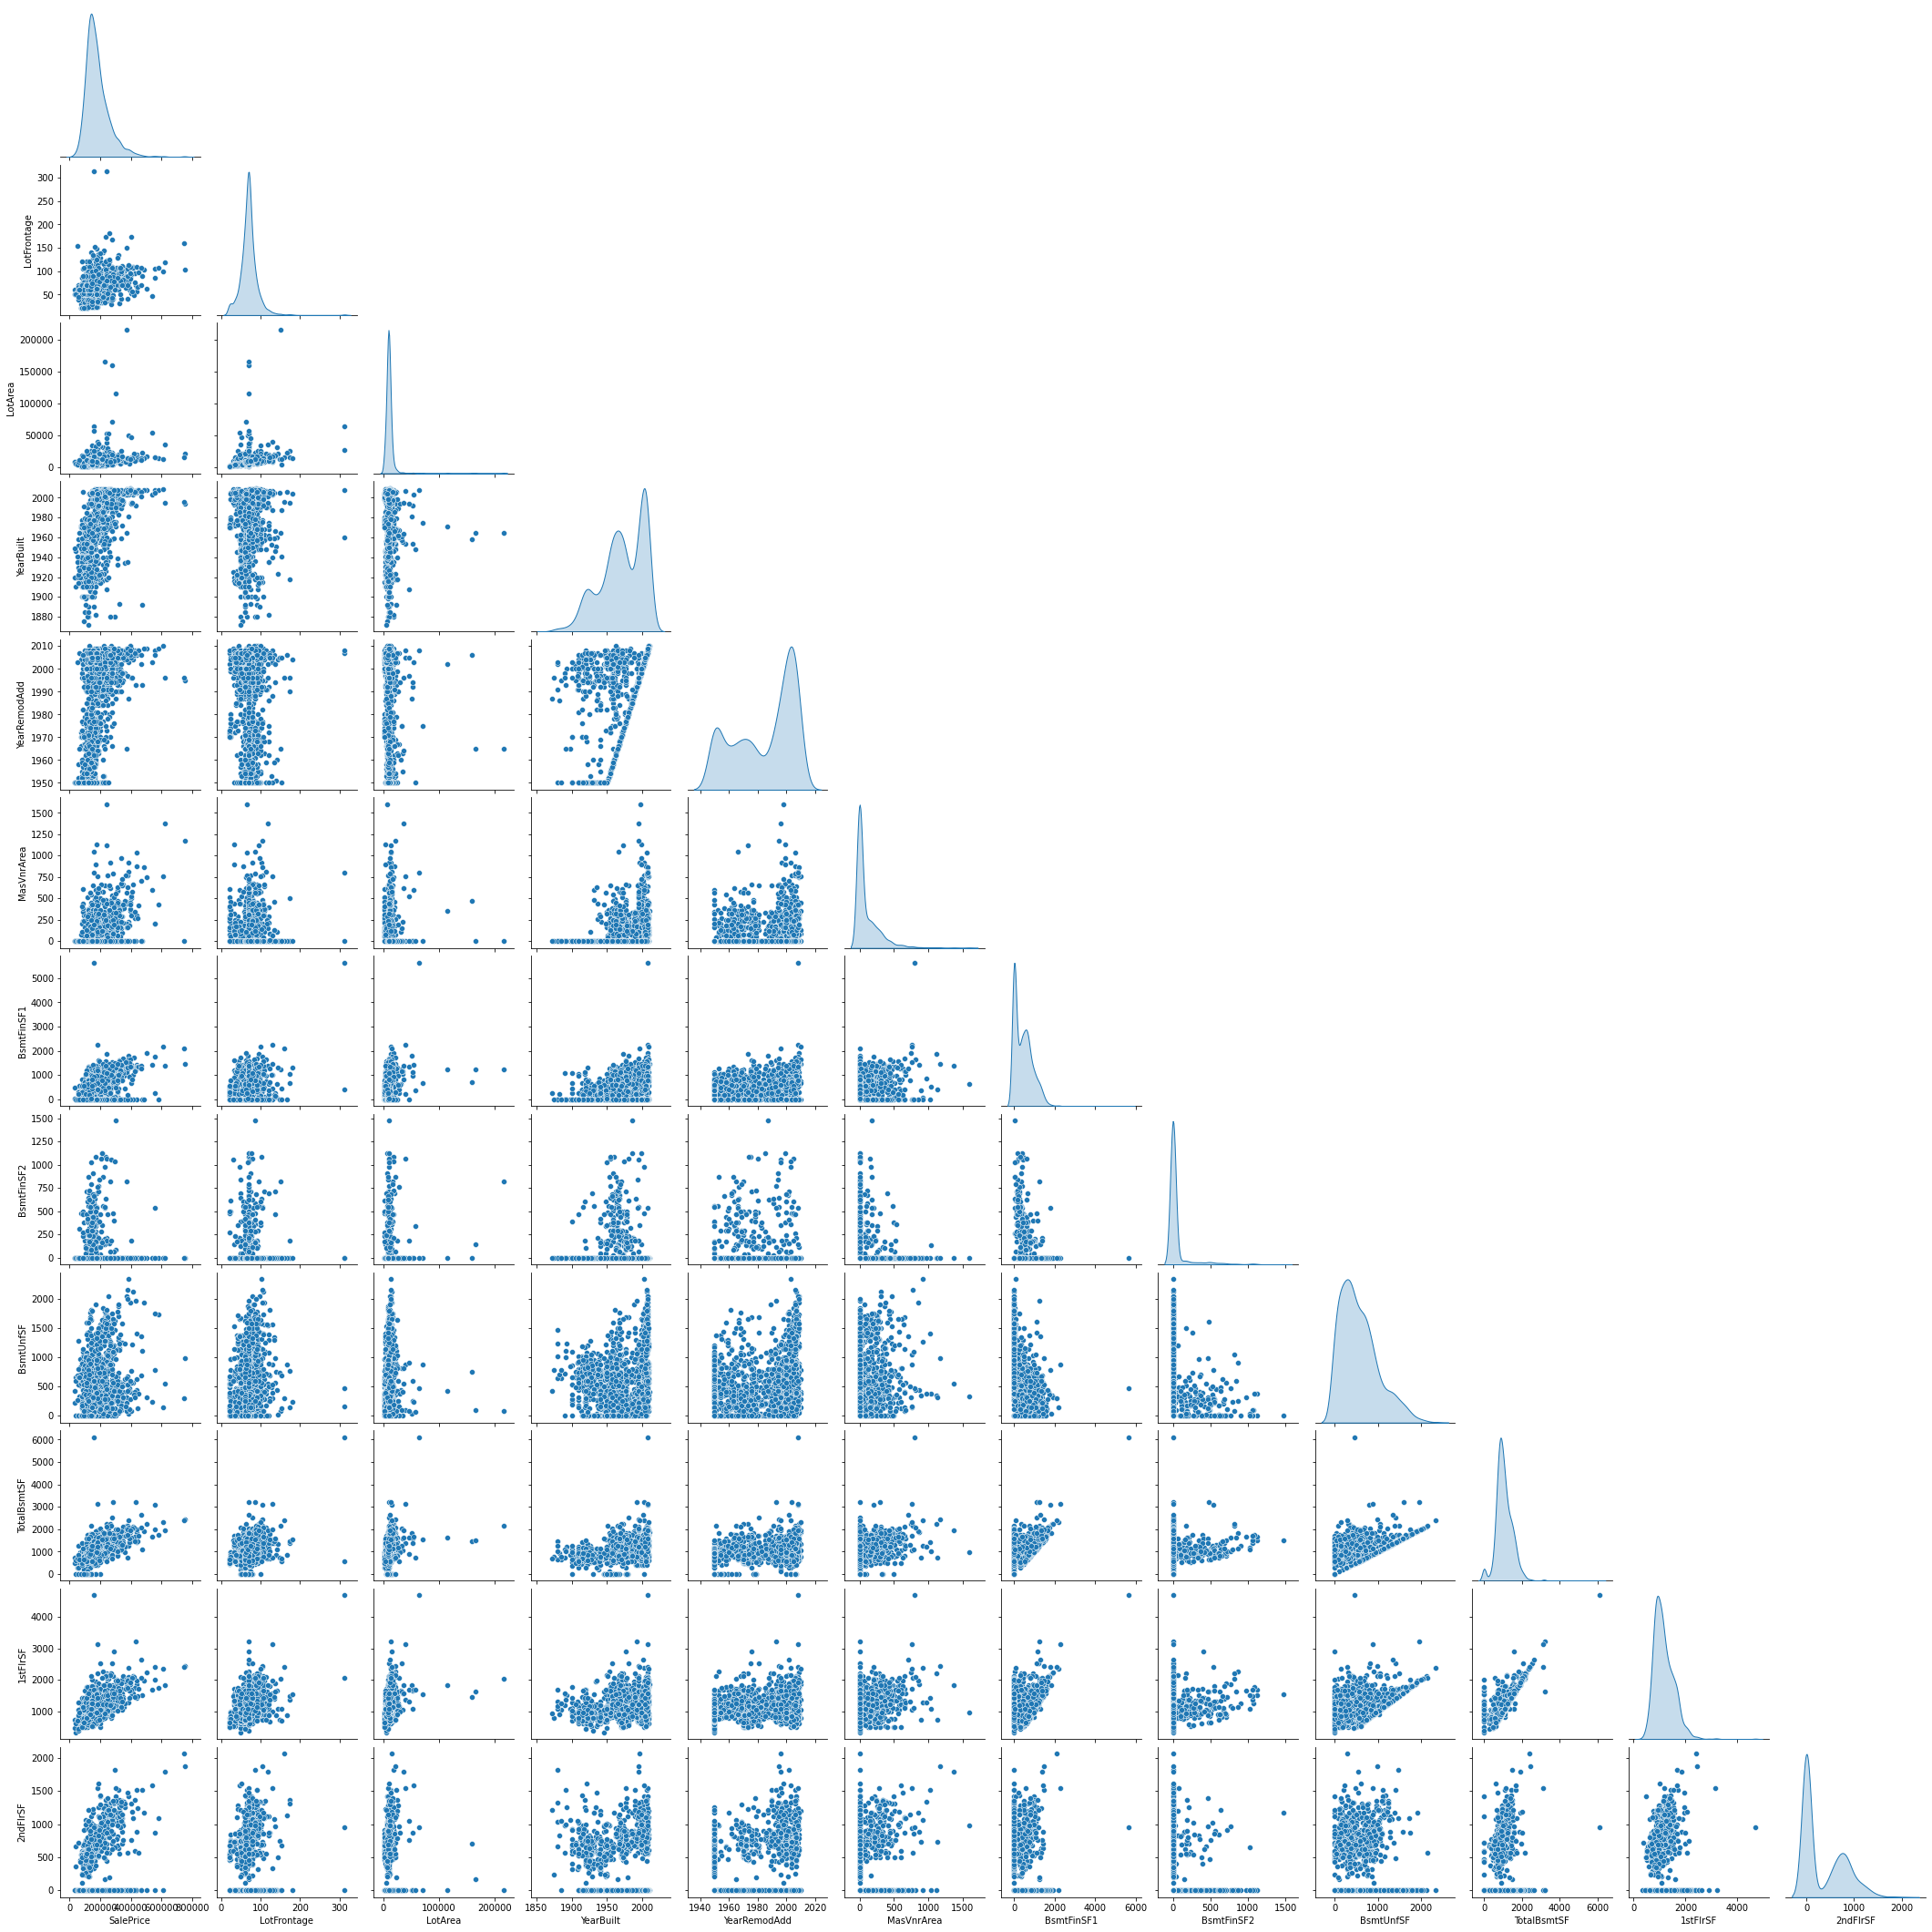

In [71]:
sns.pairplot(train, diag_kind='kde', vars = ["SalePrice", 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF'], corner=True)

The diagonal histograms in the pairplot show the distributions of individual columns along the axes and each scatter plot shows the relationship between columns along the x and y axes. For example,
  - We can see strong positive linear relationship between columns **SalePrice and 1stFlrSF(1st floor area)** where the plot is a upward diagonal. 
  - But we can infer that **LotArea and YrBuilt** don't have a linear relationship. 
  - Pairplot can tell us about very few datapoints that are far away from the clusters, they are outliers that have extreme values deviating from the normal distribution. 
  - There can be **univariate**(that deviate from other datapoints in an individual feature) and **bivariate outliers**(that have abnormal readings/values when 2 features are taken in account)<br>

Similar insights can be derived from the below pairplots too


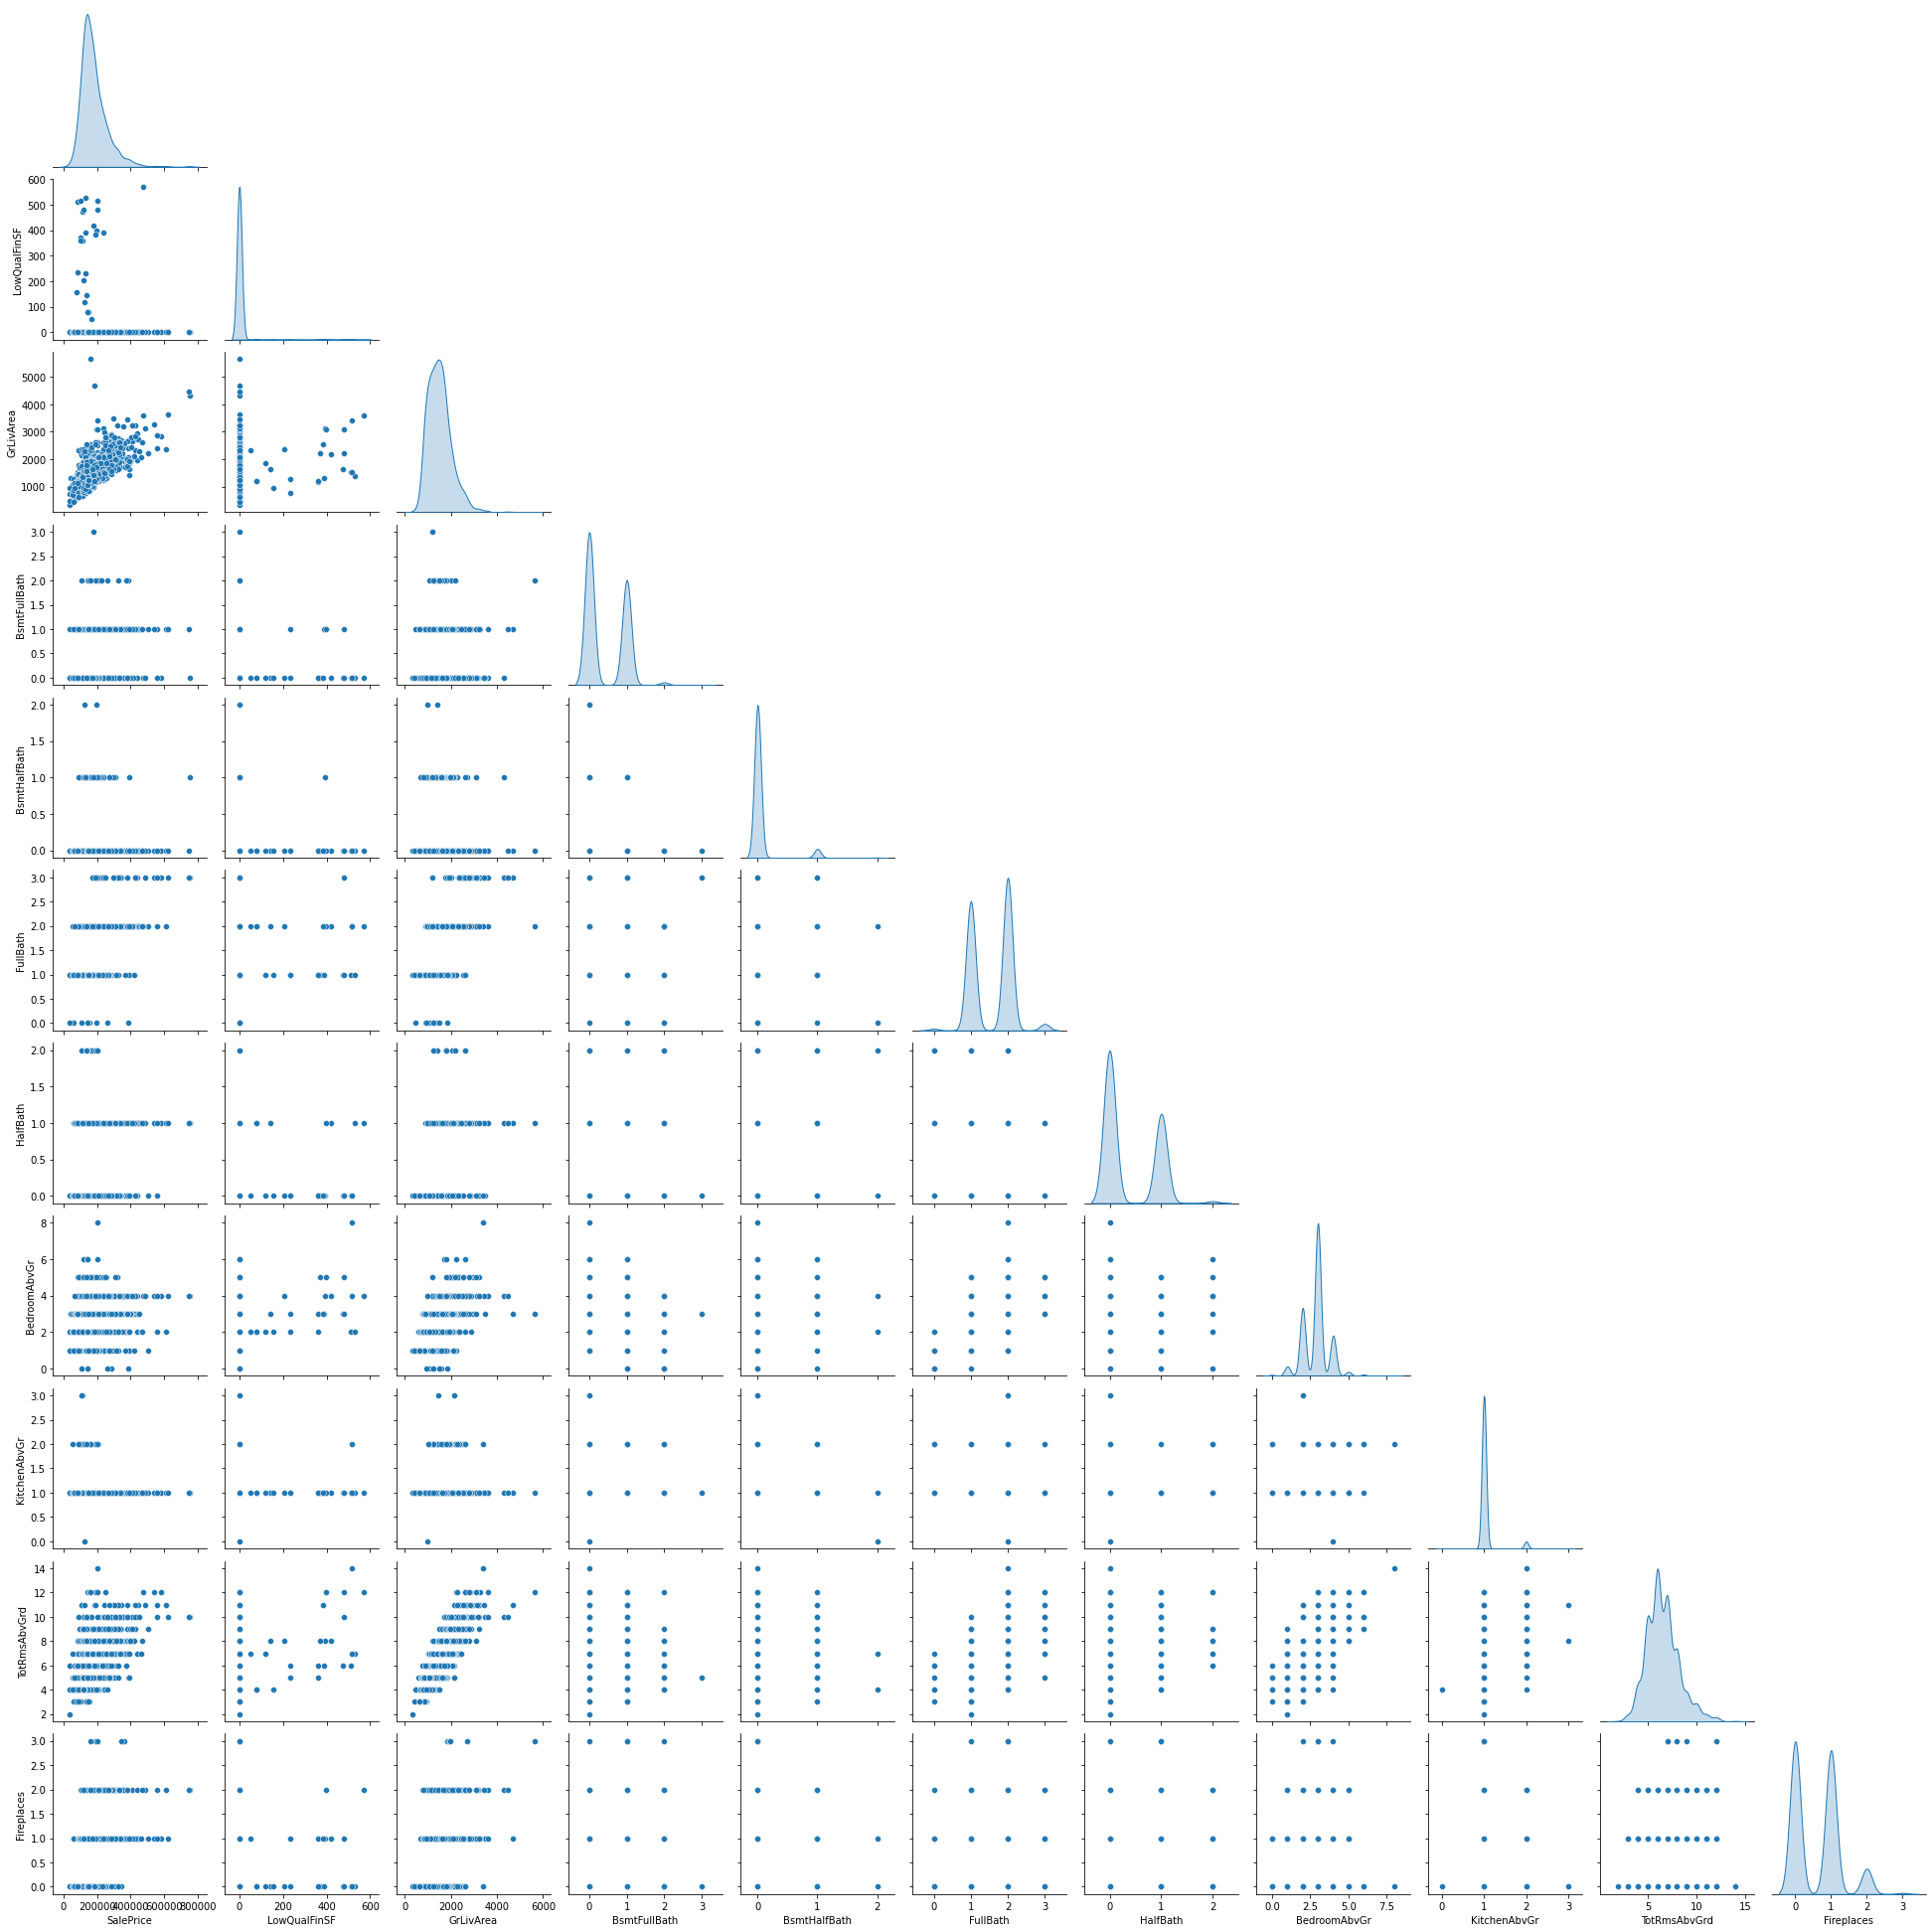

In [72]:
sns.pairplot(train, diag_kind='kde', vars = ["SalePrice", 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces'], corner=True)

**GrLivArea, TotRmsAbvGrd and BedroomAbvGr** have strong positive correlation with SalePrice

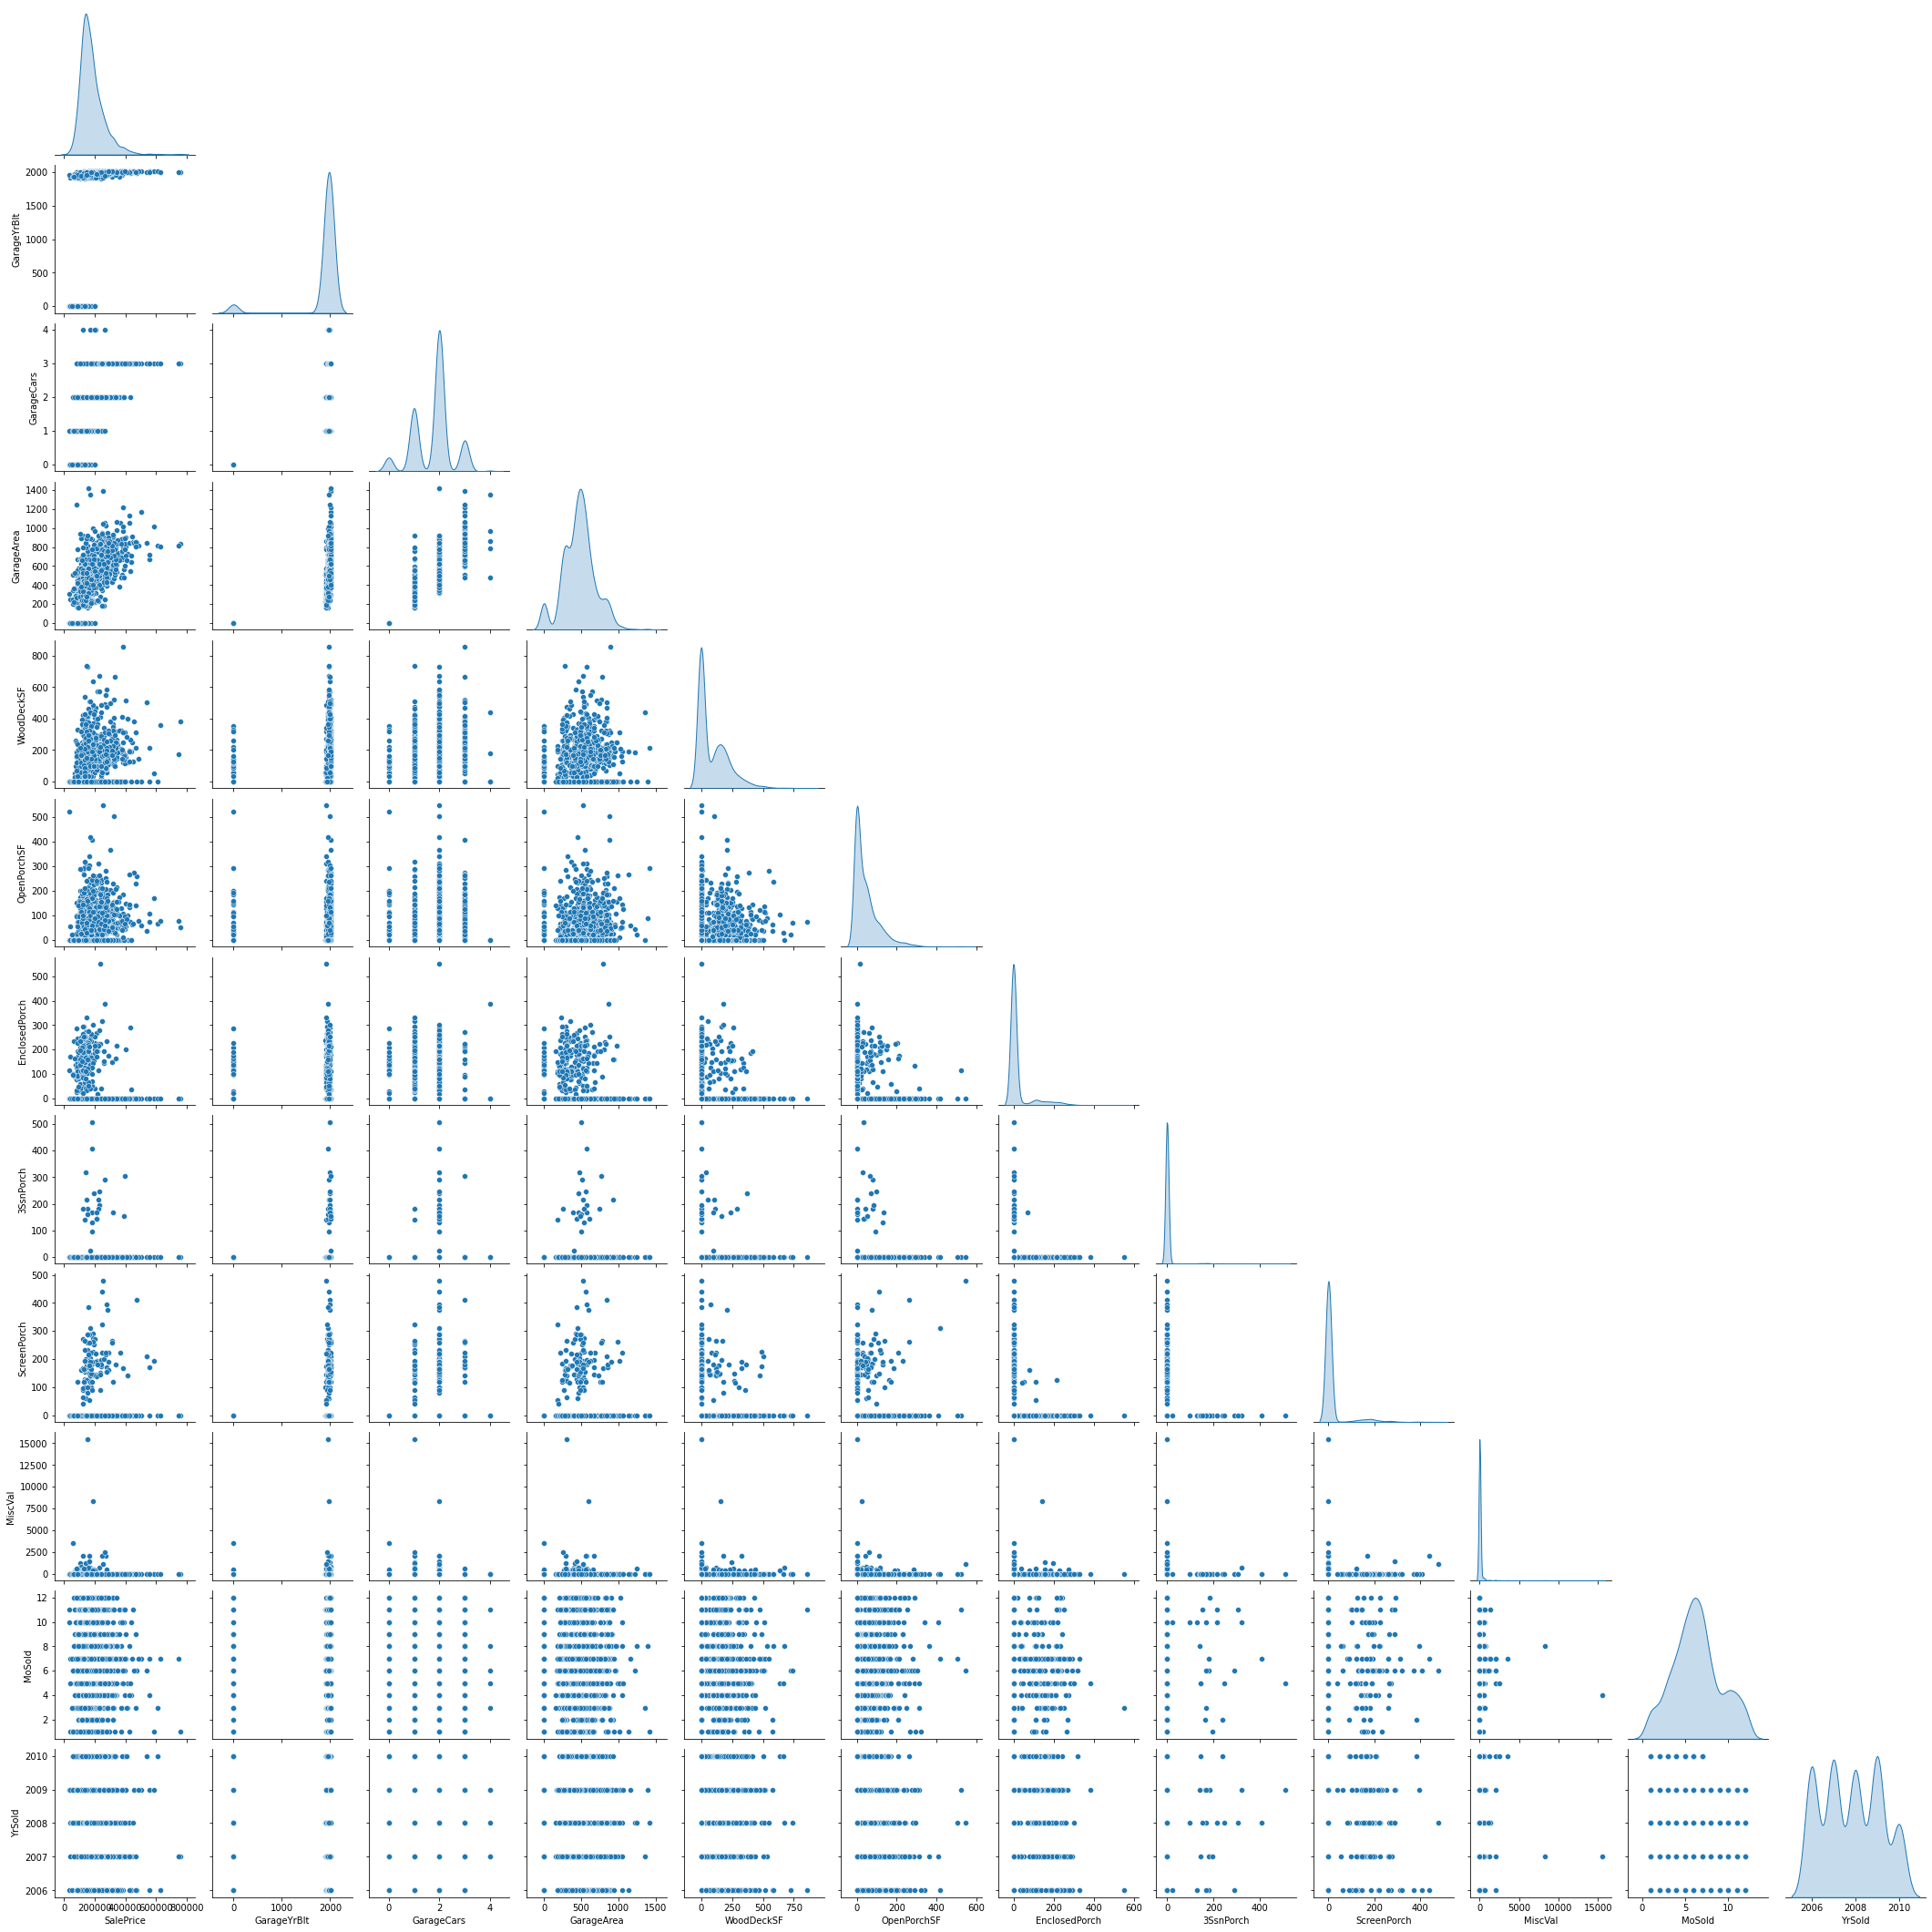

In [73]:
sns.pairplot(train, diag_kind='kde', vars = ["SalePrice", 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold'], corner=True)

**GarageArea** will be an important feature in determining *SalePrice*

So far we have visually analysed the features and their relationships. To make better decisions on selecting the best features, let's look at the statistics

## 3.2 Correlation matrix & Heatmap

Correlation values are statistical readings of relationships among numerical features<br> Correlation matrix gives the relationship between each variable with respect to every other variable in the dataset, the correlation can be:
- **positive** - when a variable responds to change in other variable in a positive way
- **negative** - when a variable responds to change in other variable in a negative way
- **zero** - no relationship between the 2 variables

In [74]:
# correlation matrix of train data
train.corr()

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,-0.009601,-0.033226,-0.012713,-0.021998,-0.051071,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.013491,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,-0.006242,0.021172,0.000712,-0.021917
LotFrontage,-0.009601,1.000000,0.306795,0.117598,0.082746,0.178699,0.215828,0.043340,0.122156,0.363358,0.414266,0.072483,0.036849,0.368392,0.091481,-0.006419,0.180424,0.048258,0.237023,-0.005805,0.320146,0.235755,0.100259,0.269729,0.323663,0.077106,0.137454,0.009790,0.062335,0.037684,0.001168,0.010158,0.006768,0.334901
LotArea,-0.033226,0.306795,1.000000,0.014228,0.013788,0.103321,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.072599,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.038068,0.001205,-0.014261,0.263843
YearBuilt,-0.012713,0.117598,0.014228,1.000000,0.592855,0.311600,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.272029,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.082746,0.013788,0.592855,1.000000,0.176529,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.146357,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.051071,0.178699,0.103321,0.311600,0.176529,1.000000,0.261256,-0.071330,0.113862,0.360067,0.339850,0.173800,-0.068628,0.388052,0.083010,0.027403,0.272999,0.199108,0.102775,-0.038450,0.279568,0.247015,0.132696,0.361945,0.370884,0.159991,0.122528,-0.109907,0.019144,0.062248,-0.029512,-0.006723,-0.008317,0.472614
BsmtFinSF1,-0.005024,0.215828,0.214103,0.249503,0.128451,0.261256,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.115843,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.005968,0.043340,0.111170,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,0.035070,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.007940,0.122156,-0.002618,0.149040,0.181133,0.113862,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.042720,0.214175,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.023837,0.034888,-0.041258,0.214479
TotalBsmtSF,-0.015415,0.363358,0.260833,0.391452,0.291066,0.360067,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.176359,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,-0.018479,0.013196,-0.014969,0.613581


A **Correlation Matrix** gives the statistical relationship between every column to every other other column in a dataframe. The diagonal values are 1 as they are correlation values of column with itself. We can also see how each column is related to target. The correlation matrix can be **visualised using a heatmap**

<AxesSubplot:>

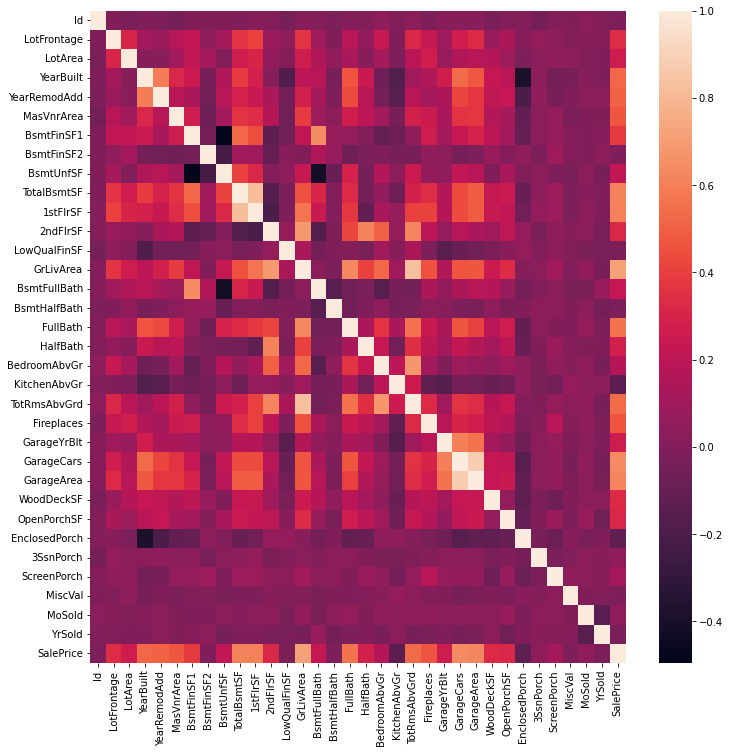

In [75]:
# visualising correaltion using a heatmap
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), cmap="rocket")

In the above heatmap, lighter the hue, more the correlation & darker the hue, lesser the correlation between variables along X & Y axis<br>We can see the highly correlated features with target (*SalePrice* in Y-axis bottom)as lighter colors in the bottom of the plot

Below features have high correlation with target as observed from the heatmap:
* OverallQual
* GeLivArea
* GarageCArs
* GArageArea
* TotalBcmtSF
* 1stFlrSF
* YearBuilt
* YearRemodAdd etc.

Let's look at the statistics of correlation value of each variable vs target<br>
Calculate the **correlation of every numerical feature against SalePrice** and sort them from max to min values

In [76]:
# calculating correaltion with SalePrice from max to min
num_cols_corr = train.corrwith(train["SalePrice"]).sort_values(ascending=False)
num_cols_corr

SalePrice        1.000000
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334901
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float64

 - A value of 1 is correlation with itself, so *SalePrice* has 1
 - We have values starting from 0.79 for *OverallQual* to 0.04 for *3SsnPorch* and then we have negative correaltion for some features
 - Correlation **above 0.3 can be taken as high positive correlation and below -0.3 as high negative correlation**
 - Negatively correlation also affects target prediction, so consider both +ve, -ve highly correlated features
 - Also, if the correlation between 2 features are **similar**, we can drop one of the features as similarly correlated features will add to the complexity of the model and don't necessarily improve the performance

In Train data, we have correlation from 0.74 to 0.04 in positive value and from -0.01 to -0.13 in negative value. Any value above 0.3 can be considered as strong correlation in positive and negative side. We don't have strong negative correlation here, so let's consider only positive correlation values<br> Let's **retain the features with threshold > 0.3**  and drop features with threshold < 0.3

In [77]:
# filtering columns with < 0.3 correlation with target
numcols_to_drop = num_cols_corr[num_cols_corr < 0.3].index
numcols_to_drop

Index(['HalfBath', 'LotArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtUnfSF',
       'BedroomAbvGr', 'ScreenPorch', 'MoSold', '3SsnPorch', 'BsmtFinSF2',
       'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')

In [78]:
# drop columns with weak correlation from train data
train.drop(numcols_to_drop, axis=1, inplace=True)


In [79]:
# drop columns with weak correlation from test data
test.drop(numcols_to_drop, axis=1, inplace=True)


## 3.3. Feature Analysis based on Correlation

Let's explore the features based on their correlation values<br>

#### 3.3.1 Analysing features having high correlation(>0.3) with target
- GrLivArea: Above grade (ground) living area square feet
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet

    - __GrLivArea__ has 0.708624 correlation with *SalePrice*, when we analyse this feature in the dataframe, this shows the *living area above ground* and this column is the sum of __1stFlrSF & 2ndFlrSF__, so we can simplify our training data by dropping the 1stFlrSF & 2ndFlrSF which are already included in *GrLivArea*

In [80]:
train.head()

,MSSubClass,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,856,GasA,Ex,Y,SBrkr,856,854,1710,2,Gd,8,Typ,0,NA,Attchd,RFn,2,548,TA,TA,Y,0,61,NA,WD,Normal,208500
1,20,RL,80.0,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,1262,GasA,Ex,Y,SBrkr,1262,0,1262,2,TA,6,Typ,1,TA,Attchd,RFn,2,460,TA,TA,Y,298,0,NA,WD,Normal,181500
2,60,RL,68.0,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,920,GasA,Ex,Y,SBrkr,920,866,1786,2,Gd,6,Typ,1,TA,Attchd,RFn,2,608,TA,TA,Y,0,42,NA,WD,Normal,223500
3,70,RL,60.0,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,756,GasA,Gd,Y,SBrkr,961,756,1717,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,642,TA,TA,Y,0,35,NA,WD,Abnorml,140000
4,60,RL,84.0,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,1145,GasA,Ex,Y,SBrkr,1145,1053,2198,2,Gd,9,Typ,1,TA,Attchd,RFn,3,836,TA,TA,Y,192,84,NA,WD,Normal,250000


In [81]:
# drop 1stFlrSF, 2ndFlrSF from train
train.drop(columns=["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)


In [82]:
# drop 1stFlrSF, 2ndFlrSF from test data
test.drop(columns=["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)


#### 3.3.2 Analysing features with similar correlation values
- GarageCars: Size of garage in car capacity

- GarageArea: Size of garage in square feet

    - __GarageArea & GarageCars__ both explain Garage size in different metrics, so we can drop *GarageArea* & retain *GarageCars* which has high correlation with *Saleprice* compared to *GarageArea*

In [83]:
# drop GarageArea from train
train.drop(columns=["GarageArea"], axis=1, inplace=True)


In [84]:
# drop GarageArea from test data
test.drop(columns=["GarageArea"], axis=1, inplace=True)


#### 3.3.3 Irrelevant Features 
- Since we dropped columns having very low correlation, the features that are related to these dropped columns would become irrelevant or have no contribution to the training data, we can identify those features and remove them form train data

In [85]:
# columns dropped earlier due to low correlation with SalePrice
numcols_to_drop

Index(['HalfBath', 'LotArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtUnfSF',
       'BedroomAbvGr', 'ScreenPorch', 'MoSold', '3SsnPorch', 'BsmtFinSF2',
       'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')

The feature *BsmtFinSF2*(Type 2 finished square feet) has been dropped now, so the feature explaining about the rating of BsmtFinSF2 will become redundant, so let's drop the feature *BsmtFinType2*

BsmtFinSF2: Type 2 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement



In [86]:
# drop BsmtFinType2 from train
train.drop(columns=["BsmtFinType2"], axis=1, inplace=True)


In [87]:
# drop BsmtFinType2 from test data
test.drop(columns=["BsmtFinType2"], axis=1, inplace=True)


#### [Go to Index](#Index)

***

## 4. Data analysis & Feature selection - Categorical

Until now, we have analysed only the numeric features and their correlation using heatmap & correlation matrix. The dataset has numerous categorical features. Let's analyse the categorical data, select relevant features & drop redundant features using statistics

In [88]:
# categorical features in train
train.select_dtypes(include='object')

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,SaleType,SaleCondition
0,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,WD,Normal
1,20,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,WD,Normal
2,60,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,WD,Normal
3,70,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NA,WD,Abnorml
4,60,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NA,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NA,WD,Normal
1456,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,Unf,TA,TA,Y,MnPrv,WD,Normal
1457,70,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,GdPrv,WD,Normal
1458,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,GasA,Gd,Y,FuseA,Gd,Typ,NA,Attchd,Unf,TA,TA,Y,NA,WD,Normal


Let's plot all the categorical variables against our target *SalePrice* and analyse their relationship. The **variance** on the *SalePrice* for each unique category of a cloumn is shown as a box plot. The plots will give a lot of insights into the data. This will be our initial step in deciding which variables are important in predicting the target and which variables would not be crucial

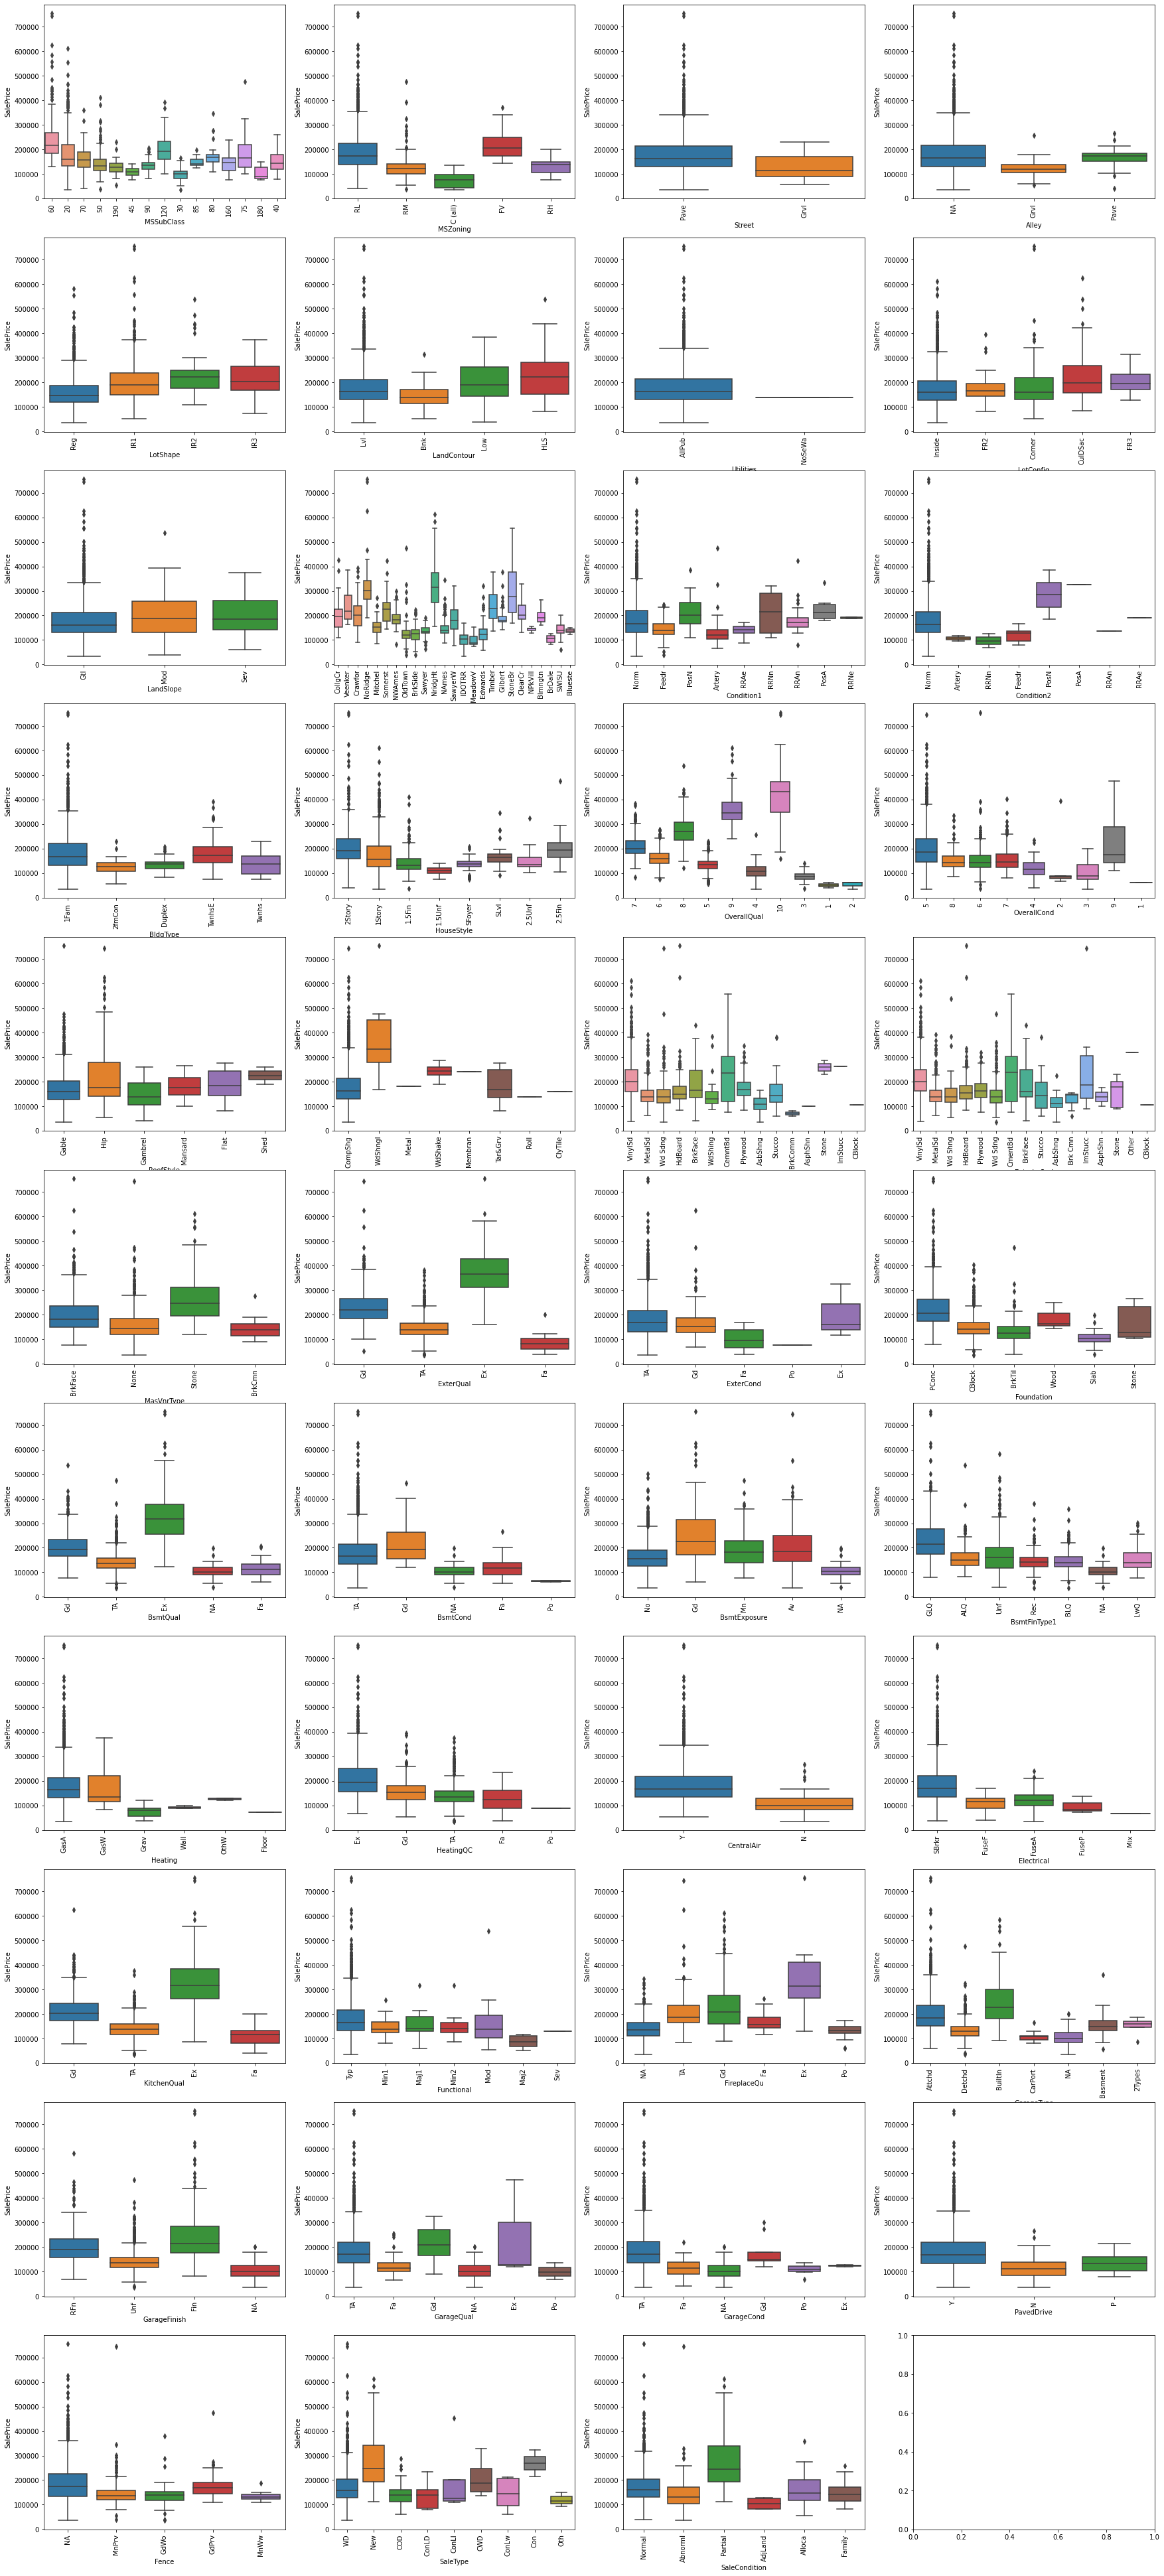

In [89]:
# plotting categorical columns vs Saleprice
fig, ax = plt.subplots(11,4, figsize=(30, 70))
for col, subplot in zip(train.select_dtypes(include='object'), ax.flatten()):
    sns.boxplot(x=train[col], y="SalePrice", data=train, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Some of the insights from the above plots:
- **Utilities** column has only 1 category *AllPub* affecting the *SalePrice*, the entire column could be redundant
- **Exterior1st & Exterior2nd** columns have very similar correlation with *SalePrice* for almost all categories, they may be duplicates
- Mean value of *SalePrice* for all categories in **Functional** column is almost same


To confirm the above points, let's do a thorough statistical exploration of the columns before acting upon the features<br>
What to lookout for in categorical columns?

- As we go through the dataframe, observe the values for each column. If we find suspicious distribution of values, analyse them statistically 
- We can observe more than 1 feature explaining same/similar properties of the house,  we could analyse and drop one of them
- If a column has same category mostly, analyse the variance of the column. Drop if the column has a very low variance

#### - Street appears to have same category *Paved* for most of the datapoints, let's verify it's variance by analysing the unique category counts
Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

In [90]:
# unique value count of categories in Street
train["Street"].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

99.6% of rows have *paved* category, only 0.4% of total data has *Grvl* category, this column has **very low variance** and will not help in predicting the target, we can drop this feature 

In [91]:
# drop Street column from train
train.drop(columns=["Street"], axis=1, inplace=True)


In [92]:
# drop Street column from test data
test.drop(columns=["Street"], axis=1, inplace=True)


#### - Similar/identical categorical features
*LandContour & LandSlope* **both explain flatness** of the property in 2 different ways

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

In [93]:
# LandContour, LandSlope columns in train
train[["LandContour", "LandSlope"]].head(20)

,LandContour,LandSlope
0,Lvl,Gtl
1,Lvl,Gtl
2,Lvl,Gtl
3,Lvl,Gtl
4,Lvl,Gtl
5,Lvl,Gtl
6,Lvl,Gtl
7,Lvl,Gtl
8,Lvl,Gtl
9,Lvl,Gtl


In [94]:
# getting unique value counts of LandContour, LandSlope
print(train["LandContour"].value_counts())
print(train["LandSlope"].value_counts())

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64


<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

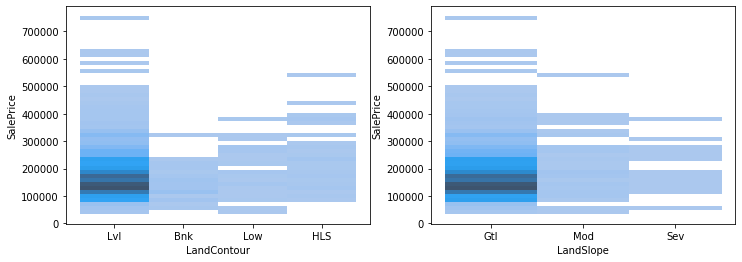

In [95]:
# plotting LandContour, LandSlope vs SalePrice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(ax=axes[0], x="LandContour", y="SalePrice", data=train)
sns.histplot(ax=axes[1], x="LandSlope", y="SalePrice", data=train)

*LandSlope* has simplified categories compared to *LandContour*, so let's drop *LandContour*

In [96]:
# drop LandContour from train
train.drop(columns=["LandContour"], axis=1, inplace=True)
train.shape

(1460, 55)

In [97]:
# drop LandContour from test data
test.drop(columns=["LandContour"], axis=1, inplace=True)


#### - Utilities appears to have same category value for many datapoints, let's check it's variance
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	

In [98]:
# getting value count of categories in utilities
train["Utilities"].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Clearly *Utilities* won't help to improve the performance of the model, it has **very low variance** in data, since all the houses fall into 1 category(well, except for only 1), so drop *Utilities* feature

In [99]:
# drop Utilities column from train
train.drop(columns=["Utilities"], axis=1, inplace=True)


In [100]:
# drop Utilities column from test
test.drop(columns=["Utilities"], axis=1, inplace=True)


#### - Other 2 similar features that explain proximity are:

Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

In [101]:
# count of unique values in Condition1, Condition2
print(train["Condition1"].value_counts())
print(train["Condition2"].value_counts())

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Drop **Condition2** since almost all(1445) houses have 'Norm' category and this column has low variance

In [102]:
# drop Condition2 from train
train.drop(columns=["Condition2"], axis=1, inplace=True)


In [103]:
# drop Condition2 from test
test.drop(columns=["Condition2"], axis=1, inplace=True)


#### - BldgType & HouseStyle are entirely different features, as we observe from the descriptions and datapoints, so they don't need any action

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	

#### - OverallQual & OverallCond are different properties. On a visual inspection of the data, the ratings are different in the 2 columns for each datapoint. So no action is needed
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

#### - Let's analyse RoofStyle & RoofMatl both explaining about roof structure, they seem to have same values when we observe in the dataframe:

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

Both clearly explain different properties, let's observe the category counts

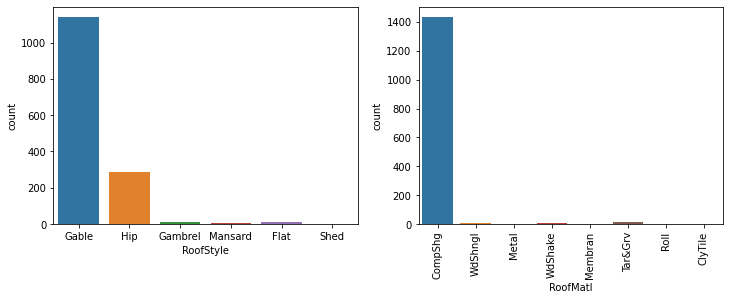

In [104]:
# plot the category count for RoofStyle, RoofMatl
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.countplot(ax=axes[0], x="RoofStyle", data=train)
sns.countplot(ax=axes[1], x="RoofMatl", data=train)
ax=plt.xticks(rotation=90)

In [105]:
print(train["RoofStyle"].value_counts())
print(train["RoofMatl"].value_counts())

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64


In *RoofMatl* 98% of datapoints fall under 1 category *CompShg*, so this feature won't be of importance in prediciting the target<br>Since it's **variance is less**, let's drop RoofMatl

In [106]:
# drop RoofMatl from train
train.drop(columns=["RoofMatl"], axis=1, inplace=True)


In [107]:
# drop RoofMatl from test
test.drop(columns=["RoofMatl"], axis=1, inplace=True)


#### 5.5 Exterior2nd is the exterior covering of house, if more than 1 material is used other than in Exterior1st, let's analyse them
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

In [108]:
# getting value counts in categories of Exterior1st, Exterior2nd
print(train["Exterior1st"].value_counts())
print(train["Exterior2nd"].value_counts())

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64


In [109]:
# observe the 2 features in dataframe
train[["Exterior1st", "Exterior2nd"]].head(20)

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
3,Wd Sdng,Wd Shng
4,VinylSd,VinylSd
5,VinylSd,VinylSd
6,VinylSd,VinylSd
7,HdBoard,HdBoard
8,BrkFace,Wd Shng
9,MetalSd,MetalSd


In [110]:
# comparing the values for all datapoints across the entire dataframe
compare = np.where(train["Exterior2nd"] == train["Exterior1st"], True, False)
comparison = np.array(compare)
np.unique(comparison, return_counts=True)

(array([False,  True]), array([ 215, 1245]))

<AxesSubplot:xlabel='Exterior2nd', ylabel='SalePrice'>

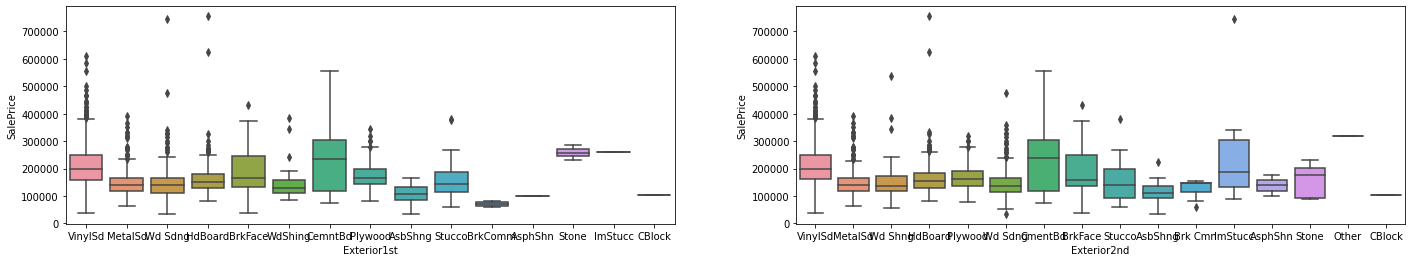

In [111]:
# plotting Exterior1st, Exterior2nd vs SalePrice
fig, axes = plt.subplots(1, 2, figsize=(24, 4))
sns.boxplot(ax=axes[0], x="Exterior1st", y="SalePrice", data=train)
sns.boxplot(ax=axes[1], x="Exterior2nd", y="SalePrice", data=train)

Though visually it seems both columns have similar categories and similar correlation with target, 15% of values differ for both columns, only 85% have the same material used for both exterior covering of the house<br>So we cannot  drop *Exterior2nd*</mark>

#### 5.6 ExterQual & ExterCond seem to explain about the quality and condition of the exterior, are they same?
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		

In [112]:
# category counts in ExterQual, ExterCond
print(train["ExterQual"].value_counts())
print(train["ExterCond"].value_counts())

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64


<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

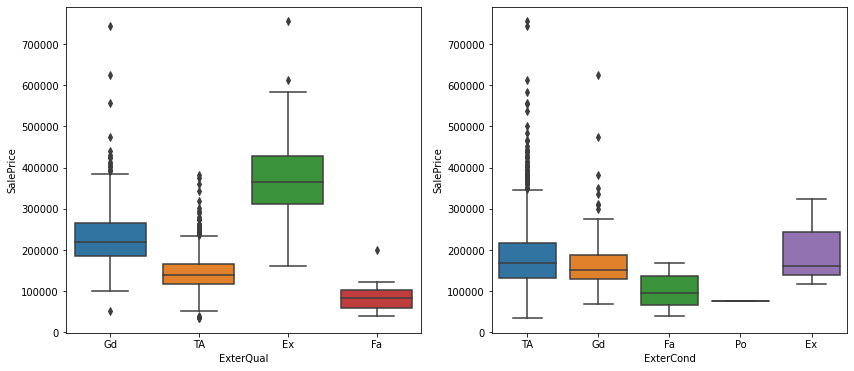

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.boxplot(ax=axes[0], x="ExterQual", y="SalePrice", data=train)
sns.boxplot(ax=axes[1], x="ExterCond", y="SalePrice", data=train)

Both are entirely different, *ExterQual* reflects the quality of exterior whereas *ExterCond* reflects the present condition of the exterior irrespective of quality, let's retain these features for training

#### - BsmtQual & BsmtCond explain the height and general condition of the basement respectively
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

In [114]:
# getting value count for categories in BsmtQual, BsmtCond
print(train["BsmtQual"].value_counts())
print(train["BsmtCond"].value_counts())

TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: BsmtQual, dtype: int64
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64


The category count is significant, we cannot drop any of the feature here, let's retain both

#### - Heating column seems to have same category for most datapoint, let's analyse
Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

In [115]:
train["Heating"].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

98% of houses in the data use same type of heating(GasA), so it's **variance negligible**, drop the *Heating* feature

In [116]:
# drop Heating from train
train.drop(columns=["Heating"], axis=1, inplace=True)


In [117]:
# drop Heating from test
test.drop(columns=["Heating"], axis=1, inplace=True)


#### - The related column *Heating QC: Heating quality and condition* - even if the type of heating is same throughout, the quality of heating may vary and it may be correlated with target. Let's analyse
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor


In [118]:
# category count for HeatingQC
train["HeatingQC"].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

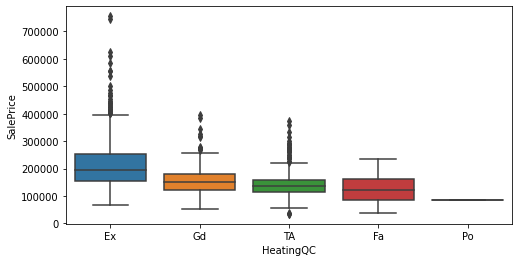

In [119]:
# plot HeatingQC vs SalePrice
plt.figure(figsize=(8,4))
sns.boxplot(x="HeatingQC", y="SalePrice", data=train)

We have all 5 categories of heating quality from Excellent to poor, as shown in the plot greatly correlates with the target. So this feature is important


#### - When going through the *CentralAir*, it looks like, it has the same category *Y* throughout. If the category is same for all the datapoints, then we can drop the column. Let's analyse for counts
CentralAir: Central air conditioning

       N	No
       Y	Yes

In [120]:
# getting value count for CentralAir
train["CentralAir"].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

We have 95(6.5% of total data) houses without central air conditioning. The variance is high enough to retain this feature in our train data

#### - GarageQual & GarageCond on visual inspection have same categories, let's explore them together
GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [121]:
print(train["GarageQual"].value_counts())
print(train["GarageCond"].value_counts())

TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64


<AxesSubplot:xlabel='GarageCond', ylabel='SalePrice'>

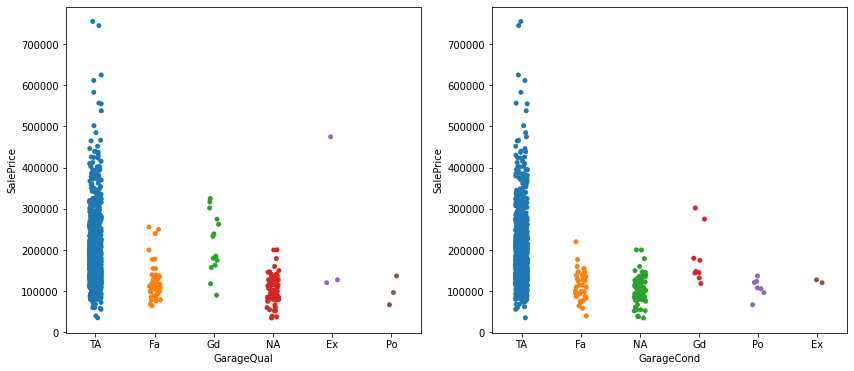

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.stripplot(ax=axes[0], x="GarageQual", y="SalePrice", data=train)
sns.stripplot(ax=axes[1], x="GarageCond", y="SalePrice", data=train)

*GarageQual* represents the Garage quality but *GarageCond* represents the condition of Garage. Except for few datapoints, 2 **columns are very similar in the category count and their correlation with *SalePrice***, let's drop *GarageCond* 

In [123]:
# drop GarageCond from train
train.drop(columns=["GarageCond"], axis=1, inplace=True)


In [124]:
# drop GarageCond from test
test.drop(columns=["GarageCond"], axis=1, inplace=True)


#### - PavedDrive feature has same category *'Y'* in visual check, let's analyse the variance
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

In [125]:
train["PavedDrive"].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Only 91% of data have category *'Y'*, so the column cannot be dropped

#### - Finally let's analyse *SaleType* or *SaleCondition* features
SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
       
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)


In [126]:
train["SaleType"].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [127]:
train["SaleCondition"].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

*SaleType or SaleCondition* columns have no abnormality in their category values, so no change is needed here

In [128]:
# check the shape of train and test after  feature selection
print(train.shape)
print(test.shape)

(1460, 50)
(1459, 49)


We have analysed all the features(both Numerical & Categorical) and based on the statistics, we dropped some features that are redundant, duplicate and those don't contribute in improving the performance of the model. The number of features have been **reduced from 80 to 50**, a **simplified model** will help in better prediciton of target

#### [Go to Index](#Index)

***

## 5. Skewness and Normalisation

As we analysed the data, the distribution plots in the pairplot show that target variable *SalePrice* and some features are **highly skewed**. Data should follow normal distribution for the model to successfully predict target, because regression based models assume **normally distributed data for good predcition results**

#### Skewness refers to the asymmetrical/distorted distribution of data along the mean. A normal distribution resembles a bell curve with data equally distributed on either side of the mean value of the data.  Skewed data has most of the values either to the right or left of the mean. Log Transformation is one of the methods used to approximate skewed data to normal distrbution

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

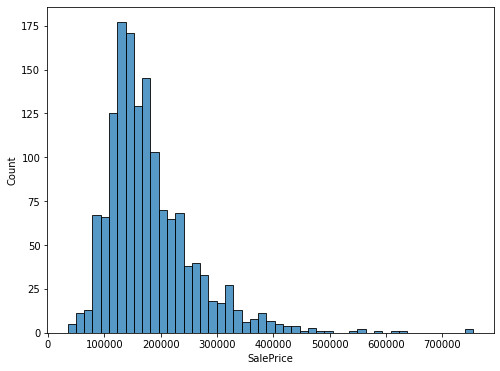

In [129]:
# skewness of target, Saleprice
plt.figure(figsize=(8,6))
sns.histplot(train["SalePrice"])

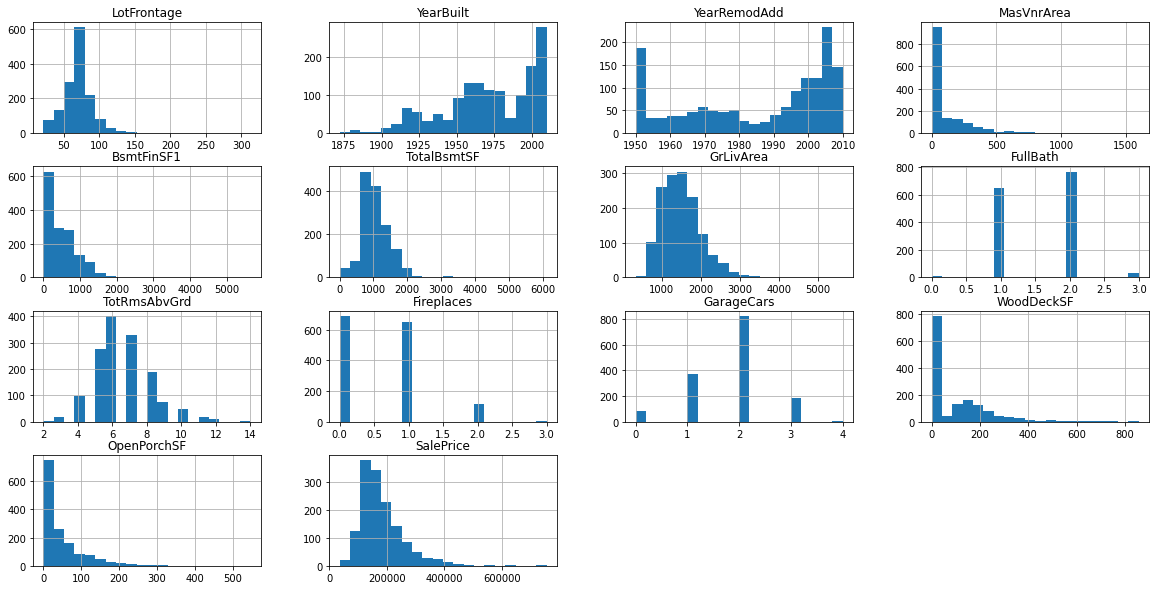

In [130]:
# skewness of numerical columns in train data
train.hist(bins=20, figsize=(20, 10))
plt.show()

As we can see here, most of the columns have skewed to the right side. **Right skewed data** model can be good in predicting only lower value ranges but predcition will be poor in higher value ranges due to less data in higher value range. The data has to be normalised before training it on an algorithm

In [131]:
# calculate skewness of numerical columns and sort values from maximun to minimum
skew = (train.select_dtypes(exclude='object').skew(axis=0).sort_values(ascending=False))
skew

MasVnrArea      2.677616
LotFrontage     2.384950
OpenPorchSF     2.364342
SalePrice       1.882876
BsmtFinSF1      1.685503
WoodDeckSF      1.541376
TotalBsmtSF     1.524255
GrLivArea       1.366560
TotRmsAbvGrd    0.676341
Fireplaces      0.649565
FullBath        0.036562
GarageCars     -0.342549
YearRemodAdd   -0.503562
YearBuilt      -0.613461
dtype: float64

**Skewness value** of < -1 and > 1 is considered that the data is highly skewed<br>
Features with skewness >1 are positively skewed and features with skewness < -1 are negatively skewed. we don't have highly negatively skewed data in train dataset<br>**Filter** features having highly positively skewed data, **skewness > 1**<br>Drop *SalePrice* from the list, we'll deal with target skew later

In [132]:
# columns in train data with skewness > 1
skew_train = skew[skew > 1].index
# only skewed features
skew_cols = skew_train.drop(["SalePrice"])

In [133]:
# columns to be normalised
skew_cols

Index(['MasVnrArea', 'LotFrontage', 'OpenPorchSF', 'BsmtFinSF1', 'WoodDeckSF',
       'TotalBsmtSF', 'GrLivArea'],
      dtype='object')

In [134]:
# applying log transformation to features in train data
for cols in skew_cols:
    train[cols] = np.log1p(train[cols])
    
train

,MSSubClass,MSZoning,LotFrontage,Alley,LotShape,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,Fence,SaleType,SaleCondition,SalePrice
0,60,RL,4.189655,NA,Reg,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,5.283204,Gd,TA,PConc,Gd,TA,No,GLQ,6.561031,6.753438,Ex,Y,SBrkr,7.444833,2,Gd,8,Typ,0,NA,Attchd,RFn,2,TA,Y,0.000000,4.127134,NA,WD,Normal,208500
1,20,RL,4.394449,NA,Reg,FR2,Gtl,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,6.886532,7.141245,Ex,Y,SBrkr,7.141245,2,TA,6,Typ,1,TA,Attchd,RFn,2,TA,Y,5.700444,0.000000,NA,WD,Normal,181500
2,60,RL,4.234107,NA,IR1,Inside,Gtl,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,VinylSd,VinylSd,BrkFace,5.093750,Gd,TA,PConc,Gd,TA,Mn,GLQ,6.188264,6.825460,Ex,Y,SBrkr,7.488294,2,Gd,6,Typ,1,TA,Attchd,RFn,2,TA,Y,0.000000,3.761200,NA,WD,Normal,223500
3,70,RL,4.110874,NA,IR1,Corner,Gtl,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,5.379897,6.629363,Gd,Y,SBrkr,7.448916,1,Gd,7,Typ,1,Gd,Detchd,Unf,3,TA,Y,0.000000,3.583519,NA,WD,Abnorml,140000
4,60,RL,4.442651,NA,IR1,FR2,Gtl,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,VinylSd,VinylSd,BrkFace,5.860786,Gd,TA,PConc,Gd,TA,Av,GLQ,6.486161,7.044033,Ex,Y,SBrkr,7.695758,2,Gd,9,Typ,1,TA,Attchd,RFn,3,TA,Y,5.262690,4.442651,NA,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,4.143135,NA,Reg,Inside,Gtl,Gilbert,Norm,1Fam,2Story,6,5,1999,2000,Gable,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,Unf,0.000000,6.860664,Ex,Y,SBrkr,7.407318,2,TA,7,Typ,1,TA,Attchd,RFn,2,TA,Y,0.000000,3.713572,NA,WD,Normal,175000
1456,20,RL,4.454347,NA,Reg,Inside,Gtl,NWAmes,Norm,1Fam,1Story,6,6,1978,1988,Gable,Plywood,Plywood,Stone,4.787492,TA,TA,CBlock,Gd,TA,No,ALQ,6.673298,7.341484,TA,Y,SBrkr,7.637234,2,TA,7,Min1,2,TA,Attchd,Unf,2,TA,Y,5.857933,0.000000,MnPrv,WD,Normal,210000
1457,70,RL,4.204693,NA,Reg,Inside,Gtl,Crawfor,Norm,1Fam,2Story,7,9,1941,2006,Gable,CemntBd,CmentBd,None,0.000000,Ex,Gd,Stone,TA,Gd,No,GLQ,5.620401,7.050123,Ex,Y,SBrkr,7.758333,2,Gd,9,Typ,2,Gd,Attchd,RFn,1,TA,Y,0.000000,4.110874,GdPrv,WD,Normal,266500
1458,20,RL,4.234107,NA,Reg,Inside,Gtl,NAmes,Norm,1Fam,1Story,5,6,1950,1996,Hip,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,TA,TA,Mn,GLQ,3.912023,6.983790,Gd,Y,FuseA,6.983790,1,Gd,5,Typ,0,NA,Attchd,Unf,1,TA,Y,5.905362,0.000000,NA,WD,Normal,142125


In [135]:
# applying log transformation to features in test data
for cols in skew_cols:
    test[cols] = np.log1p(test[cols])


In [136]:
# applying log transformation to target
train["SalePrice"] = np.log1p(train["SalePrice"])
train["SalePrice"]

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

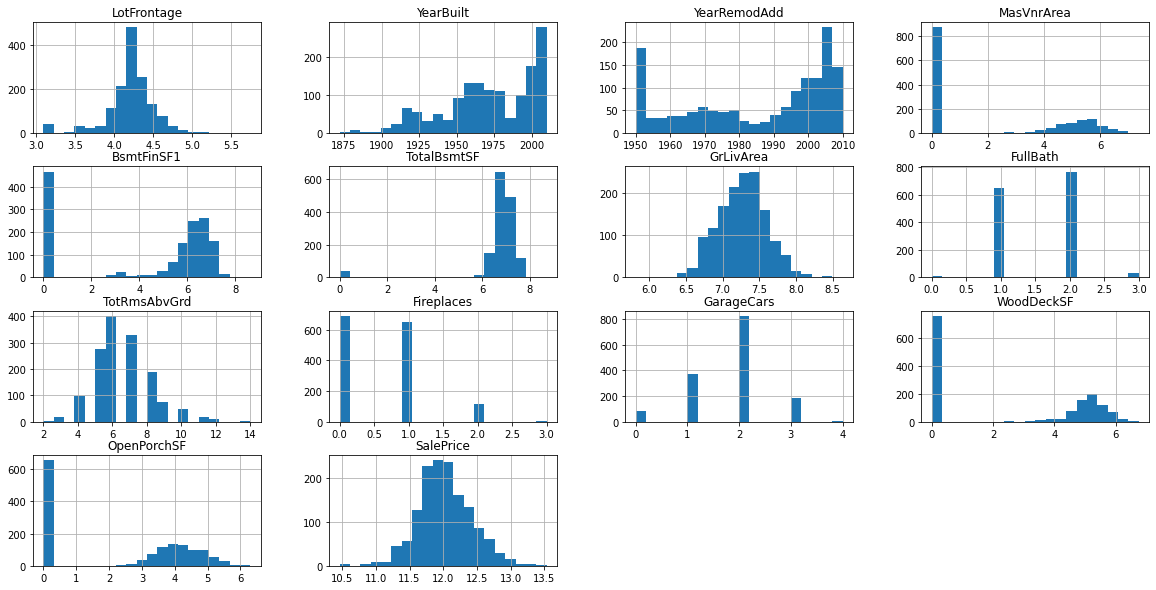

In [137]:
# visualising normalised train data
train.hist(bins=20, figsize=(20, 10))
plt.show()

After log transformation, the data has been approximated to a normal distribution

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

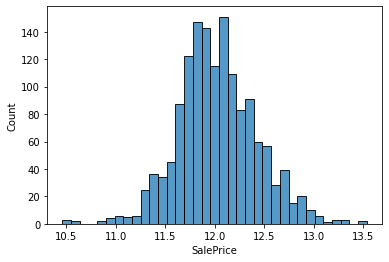

In [138]:
# visualising normalised target
sns.histplot(train["SalePrice"])

#### [Go to Index](#Index)

***

## 6. Training set-Validation set split, Pre-processing steps: OneHotEncoding, Standardisation

Separate the target *SalePrice* from the train data, the **features** are stored in the variable **X** and the **target** in **y**

In [139]:
X = train.drop(["SalePrice"], axis=1)
y = train["SalePrice"]
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1460, 49)
Shape of y: (1460,)


In [140]:
# filter the categorical columns from X
cat_cols = X.select_dtypes(include="object").columns
cat_cols

Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'PavedDrive', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

The model should be trained on a set of data and **validated on another new set of data**. Here we split the features and target in the ratio of 70% training data and 30% validation data. A validation dataset is needed to validate the results of a trained model. We will train a model using X_train, y_train and use our model on X_val to predict y values

In [141]:
# train test split - split X, y into X_train, X_val, y_train, y_val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (1022, 49)
Shape of y_train: (1022,)
Shape of X_val: (438, 49)
Shape of y_val: (438,)


Machine learning algorithms can only take numerical inputs, so we need to **encode the categories** in categorical columns into numerical values<br> **One hot encoding** is one of the methods to encode categories. We will build a pipeline below using **ColumnTransformer** to do this task, where it will encode the categorical columns but will 'passthrough' the numerical columns without any change

In [142]:
# define column transformer pipeline
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

col_transform = ColumnTransformer(
    transformers=[("categorical", categorical_transformer,cat_cols)], remainder='passthrough'
)

In [143]:
# fit-transform column transformer on the training set X_train and based on the parameters, transform the validation set X_val
X_train_encoded = col_transform.fit_transform(X_train)
X_val_encoded = col_transform.transform(X_val)
print("Shape of X_train after encoding:", X_train_encoded.shape)
print("Shape of X_val after encoding:", X_val_encoded.shape)

Shape of X_train after encoding: (1022, 259)
Shape of X_val after encoding: (438, 259)


In [144]:
# apply column transformer and transform the test data
test_encoded = col_transform.transform(test)
print("Shape of test data after encoding:", test_encoded.shape)

Shape of test data after encoding: (1459, 259)


One hot encoding method will increase the number of columns since it encodes and transforms each category in a column into a new column. It also change the names of the categorical features into numericals, we need our **original column names** for evaluating our model, so get the original feature names form encoded data. after encoding, the column names have their respective category

In [145]:
# this code will get the original feature names along with their categories
onehot_cols = col_transform.named_transformers_["categorical"].named_steps["onehot"].get_feature_names(cat_cols)

We have extracted only the categorical column names after encoding, to get all the column names from the training data, append the numerical columns to the list

In [146]:
# append the numerical columns with the encoded columns
original_feature_names = list(onehot_cols) + list(train.select_dtypes(exclude="object").columns.drop(["SalePrice"]))
original_feature_names

['MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Grvl',
 'Alley_NA',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neig

The data on which our model is to be trained has all the different ranges of values and different metrics in data such as area in square feet, years, ratings from 1 to 10 etc., to get a uniformity in values, we need to **scale the data**. **StandardScaler** is one method of standardisation of data

In [147]:
# fit-transform StandardScale on the training set X_train and based on the parameters, transform the validation set X_val
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

In [148]:
# apply StandardScaler and standardise the test data
test_scaled = scaler.transform(test_encoded)

#### [Go to Index](#Index)

***

## 7. Extreme Gradient Boosting(XGB) Regressor

We have completed the pre-processing of training and validation datasets. Now, we are ready to train the data on our model.<br>We are training the data on an XGBoost model. **Extreme Gradient(XG) Boosting** is an improvisation of an **ensemble algorithm** called Gradient Boosting and is known for great accuracy and speed

Here is a complete reference to XGBoost Classification & Regression models (https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349)

In [149]:
# create an instance of the class XGBoost regressor
xgb = xgb.XGBRegressor()

## 7.1 Hyperparameter Tuning

Hyper parameter tuning is process of choosing the right combination of parameters for an estimator from a given set of parameters, to get the best prediction in a model. Here we're using Grid Search Cross validation for tuning method

In [150]:
# define the parameter grid for a XGBoost model to use for Gridsearchcv
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [500, 1000],
           'colsample_bytree': [0.3, 0.7],
           'alpha' : [0.1, 0.2, 0.3]}

In [151]:
# perform a gridsearch for the combination of parameters in 'params' grid for the regressor to find the model of least negative mean squared error
xg_reg = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   cv=3,
                   verbose=0)

In [152]:
# fit and train our X_train and y_train datasets on the gridsearch to get the best model
xg_reg.fit(X_train_scaled, y_train)
# use the best model from the gridsearch on X_test data to predict y values, y_predict
y_predict = xg_reg.predict(X_val_scaled)

In the above step we are predicting y_predict by applying our trained model on X_val_scaled, validation data. By comparing the predicted values y_predict to the actual value y_val, we can calculate the error<br>**Root Mean Squared Error**, rmse is the error metric used to evaluate the model. The error should be the least possible for our prediction to be accurate

In [153]:
# calculate the mean absolute error and root mean squared error
mae = mean_absolute_error(y_val, y_predict)
print("Mean Absolute error in log scale, mae:", mae)
mse = mean_squared_error(y_val, y_predict)
rmse = np.sqrt(mse)
print("Root Mean Squared Error in log scale, rmse:", rmse)

Mean Absolute error in log scale, mae: 0.08916558897429193
Root Mean Squared Error in log scale, rmse: 0.13311770584054516


In [154]:
# get the best parameter combination and the lowest root mean squared error(RMSE) for the best model
print("Best parameters:", xg_reg.best_params_)
print("Lowest RMSE: ", (-xg_reg.best_score_)**(1/2.0))

Best parameters: {'alpha': 0.1, 'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  0.12955742881197257


In [155]:
# best estimator from gridsearch is our final model
print("Best Estimator: ", xg_reg.best_estimator_)
model = xg_reg.best_estimator_

Best Estimator:  XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


## 7.2 Plotting Decision trees

Decision trees will give us insights on how the gradient boosting model works and the split decisions made at each feature node till reaching a leaf node

In [156]:
# match the original feature names to the feature names of the model
model.get_booster().feature_names = original_feature_names

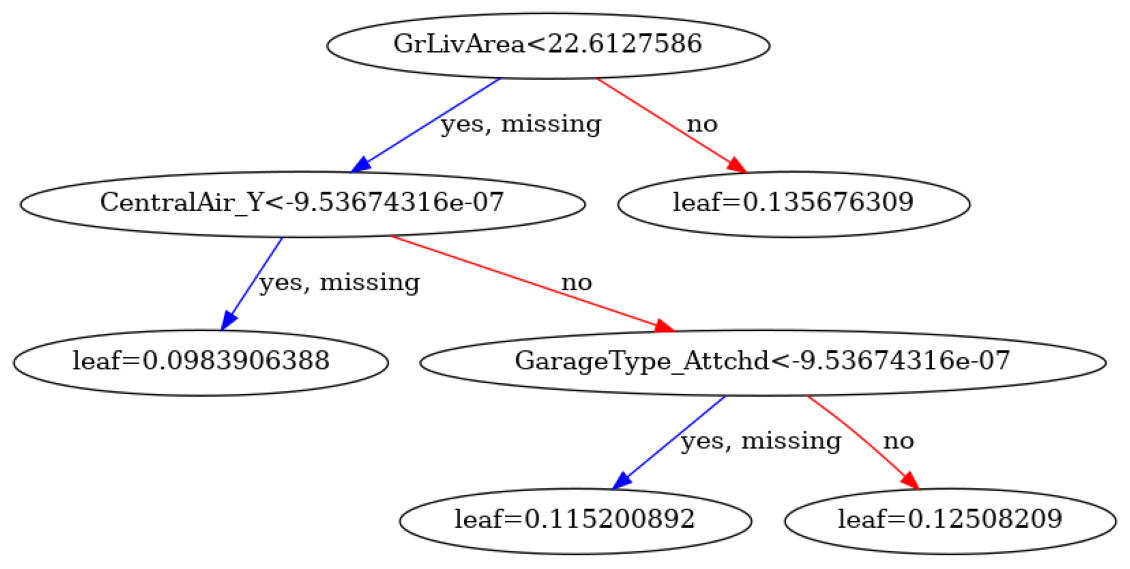

In [157]:
# plot the decision tree in the model with features, feature values for each split and output leaf nodes
fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(model, num_trees=30, ax=ax)
plt.show()

## 7.3 Feature importance

<Figure size 1440x1440 with 0 Axes>

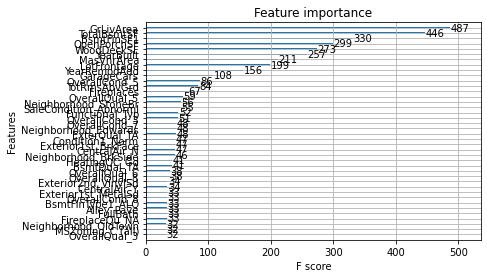

In [158]:
# plot the important features selected by the model in order of their importances
plt.figure(figsize = (20, 20))
plot_importance(model, max_num_features=40, importance_type='weight')
plt.rcParams["figure.figsize"] = (20, 20)

Feature importance plot shows the **most important features** used for prediction sorted in order of their importances<br>
TotalBsmtSF(Total Basement area) is the top feature determining the target value, followed by GrLivArea(area above the ground), BsmtFinSF1(Type 1 finished area) and others

Here is a guide to XGBoost Decision Tree and feature importance visualisations(https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/)

## 7.4 Predicted vs Actual plot

[Text(0, 0.5, 'True values for SalePrice'),
 Text(0.5, 0, 'Predicted values for SalePrice'),
 Text(0.5, 1.0, 'True SalePrice vs Predicted SalePrice ')]

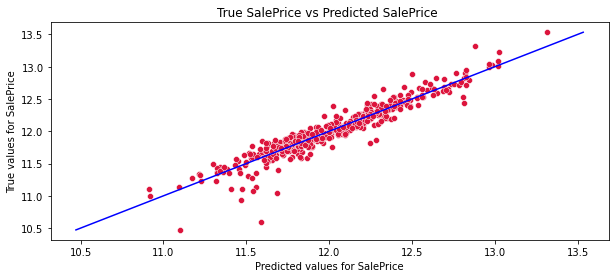

In [159]:
# plot the actual SalePrice values vs predicted SalePrice values
plt.figure(figsize = (10, 4))
ax = sns.scatterplot(y=y_val, x=y_predict, color='crimson')
p1 = max(max(y_predict), max(y_val))
p2 = min(min(y_predict), min(y_val))
plt.plot([p1, p2], [p1, p2], 'b-')
ax.set(ylabel = "True values for SalePrice", xlabel = "Predicted values for SalePrice", title ="True SalePrice vs Predicted SalePrice ")

The plot shows a good fit of the predicted values to the actual values along the regression line<br>Overall, the values hold together without much devation form the line showing the **error in prediction is very less**. However, the error is more in lower value range and higher value range of SalePrice

## 7.5 Residual plot

[Text(0.5, 0, 'Predicted values'),
 Text(0, 0.5, 'Residuals'),
 Text(0.5, 1.0, 'Residual plot')]

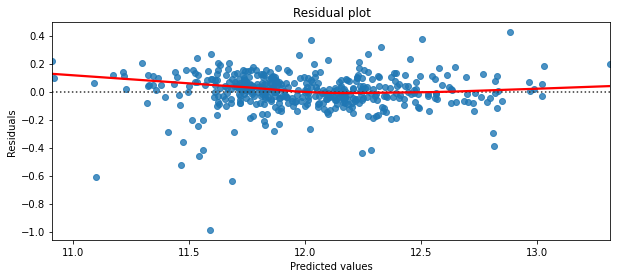

In [160]:
# plot the error values vs the predicted values of target
plt.figure(figsize = (10, 4))
ax = sns.residplot(x=y_predict, y = (y_val - y_predict), lowess=True, line_kws={'color': 'red'})
ax.set(xlabel = "Predicted values", ylabel = "Residuals", title ="Residual plot")

The residuals or error is the difference between the actual and predicted SalePrice. The plot has residuals along the y-axis and it's corresponding predcited SalePrice along the x-axis
- The points above the 0 mid-line in y-axis(positive residuals) represent low prediction compared to actual SalePrice, the points below the 0 mid-line in y-axis(negative residuals) represent high prediction compared to actual SalePrice
- The residual points on the 0 mid-line shows zero error
- Most points clustering around the zero line shows error is lower
- The plot should not have specific cluster or clear pattern for the model to be good, if the plot has a clear pattern/shape, then there is room for improvement in a model. Plot **shape** of our model is **random** and our linear assumption hold true 
- The red line along the zero error line shows that the model has predicted well for most cases except for low range value in SalePrice

## 7.6 Learning Curve-Bias/variance Tradeoff

Learning curves can give us insights on how to further improve our model

(0.0, 0.6)

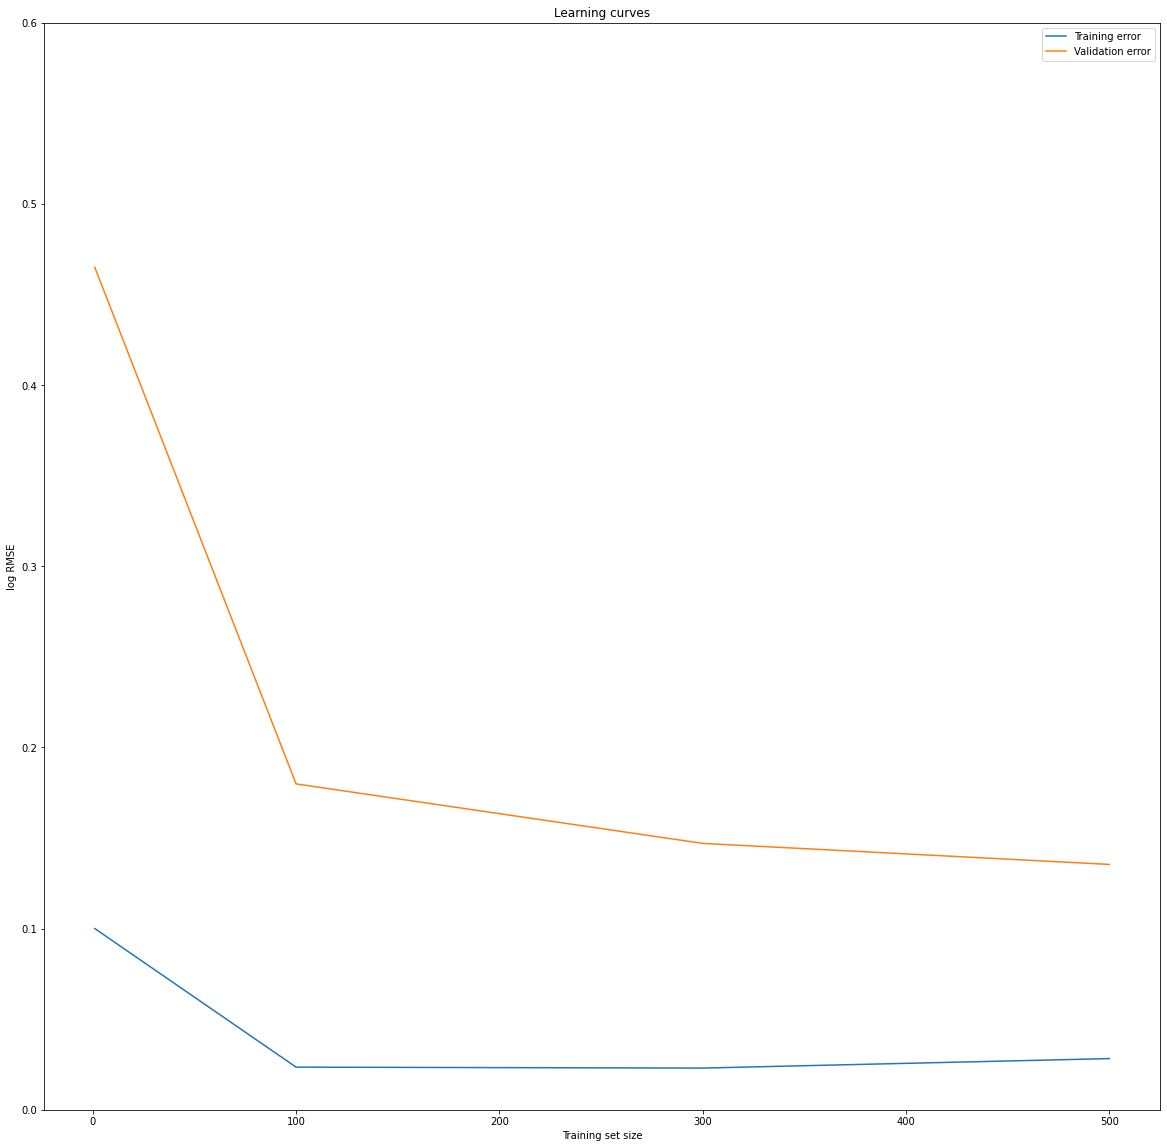

In [161]:
train_sizes, train_scores, validation_scores = learning_curve(model, X_train_scaled, y_train,
                                            train_sizes=[1, 100, 300, 500], cv =3, scoring = 'neg_root_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('log RMSE')
plt.xlabel('Training set size')
plt.title('Learning curves')
plt.legend()
plt.ylim(0,0.6)

#### *Insights from Learning Curves:*

**Total error in prediction = Bias + variance + Irreducible error**
 - Irreducible error cannot be minimised, this is the error made by the algorithm
 - We can reduce the error due to bias and variance
 - **Bias**: Error showing how far the predicted values are from actual value
   - In our model, bias is low(the training error curve shows low error)
 - **Variance**: Error when the model is subjected to a new set of data
   - In our model, variance is high (the gap between training and validation error curves)
 - Our model has **low bias, high variance**. It suffers from **overfitting**
 - When the 2 curves converge, variance error will reduce. The curves are starting to converge, we can provide more training data to reduce the gap
 - We can improve our model by
   - **increasing data** for training, so that the model learns from the data and becomes generalised
   - decreasing the complexity of data, by **reducing some of the features**

More on learning curves here (https://hshan0103.medium.com/understanding-bias-variance-trade-off-from-learning-curve-a64b4223bb02)

#### [Go to Index](#Index)

***

## 8. Predict target for Test Data

Our test data is already cleaned and pre-processed, let's fit our trained model on test data to predict target

In [162]:
# predict target and inverse the log transformation to get values on original scale
test_target = np.exp(model.predict(test_scaled))
test_target

array([118501.195, 154976.81 , 194519.62 , ..., 157513.44 , 122981.42 ,
       219641.97 ], dtype=float32)

In [163]:
# define a dataframe with target as SalePrice column, use Id columns from sample submission index
df_out = pd.DataFrame(test_target, columns=["SalePrice"])
df_out["Id"] = sample_submission["Id"]

# dataframe for submission
submission = df_out[["Id", "SalePrice"]]
submission

,Id,SalePrice
0,1461,118501.195312
1,1462,154976.812500
2,1463,194519.625000
3,1464,204559.609375
4,1465,186058.734375
...,...,...
1454,2915,83024.656250
1455,2916,81631.296875
1456,2917,157513.437500
1457,2918,122981.421875


In [164]:
# convert to csv format for submission
submission.to_csv("House_price_submission", index=False)

***